In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy
import pyarrow


import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

import patch
import kinematics
import HMM

In [3]:
def DeleteRows(mouse_pos):
    mouse_pos_reset = mouse_pos.reset_index()


    grouping_var = mouse_pos_reset.groupby(mouse_pos_reset.index // 5).ngroup()
    agg_dict = {col: 'mean' for col in mouse_pos_reset.columns if col != 'time'}
    agg_dict['time'] = 'last'

    mouse_pos_grouped = mouse_pos_reset.groupby(grouping_var).agg(agg_dict)

    mouse_pos_grouped.set_index('time', inplace=True)
    mouse_pos_grouped.index.name = None
    
    return mouse_pos_grouped

In [4]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [5]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [6]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

In [14]:
short_sessions_patch1, short_sessions_patch2 = [],[]
for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(j)
    print(title)
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
    mouse_pos = DeleteRows(mouse_pos)
    
    x = mouse_pos['smoothed_position_x']
    y = mouse_pos['smoothed_position_y']
    speed = mouse_pos['smoothed_speed']
    acceleration = mouse_pos['smoothed_acceleration']
    VisitPatch1 = max(mouse_pos['Patch1_Visit'])
    VisitPatch2 = max(mouse_pos['Patch2_Visit'])
    print("Patch 1 Visits: ", VisitPatch1, "  ", "Patch 2 Visits: ", VisitPatch2)
    Patch_Pref = 1 if np.mean(VisitPatch1) > np.mean(VisitPatch2) else 2
    Patch_UnPref = 1 if np.mean(VisitPatch1) < np.mean(VisitPatch2) else 2
    
    if Patch_Pref == 1: short_sessions_patch1.append(j)
    else: short_sessions_patch2.append(j)

ShortSession0
Patch 1 Visits:  27.0    Patch 2 Visits:  23.0
ShortSession1
Patch 1 Visits:  75.0    Patch 2 Visits:  57.0
ShortSession2
Patch 1 Visits:  99.0    Patch 2 Visits:  89.0
ShortSession3
Patch 1 Visits:  54.0    Patch 2 Visits:  21.0
ShortSession4
Patch 1 Visits:  39.0    Patch 2 Visits:  13.0
ShortSession5
Patch 1 Visits:  129.0    Patch 2 Visits:  88.0
ShortSession6
Patch 1 Visits:  43.0    Patch 2 Visits:  48.0
ShortSession7
Patch 1 Visits:  251.0    Patch 2 Visits:  148.0
ShortSession8
Patch 1 Visits:  69.0    Patch 2 Visits:  35.0
ShortSession9
Patch 1 Visits:  143.0    Patch 2 Visits:  44.0
ShortSession10
Patch 1 Visits:  20.0    Patch 2 Visits:  6.0
ShortSession11
Patch 1 Visits:  70.0    Patch 2 Visits:  12.0


# Fit HMM

## Short Sessions

In [7]:
# Compute and Save Patch Information
'''for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)
                
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
            
    temp_df = mouse_pos.dropna(subset=['x', 'y'])
    first_valid_index = temp_df.index[0]
    last_valid_index = temp_df.index[-1]
    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]
    mouse_pos = kinematics.FixNan(mouse_pos)
        
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
            
    patch.AddKinematics(title, mouse_pos)
    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]
        
    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
    patch.AddWeight(mouse_pos, weight)
        
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
            
    patch.InPatch(mouse_pos, pellets_patch1, pellets_patch2)
    
    mouse_pos.to_parquet(title+'mousepos.parquet', engine='pyarrow')'''

"for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):\n    title = 'ShortSession'+str(i)\n    print(title)\n                \n    start, end = session.enter, session.exit\n    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)\n            \n    temp_df = mouse_pos.dropna(subset=['x', 'y'])\n    first_valid_index = temp_df.index[0]\n    last_valid_index = temp_df.index[-1]\n    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]\n    mouse_pos = kinematics.FixNan(mouse_pos)\n        \n    start, end = mouse_pos.index[0], mouse_pos.index[-1]\n            \n    patch.AddKinematics(title, mouse_pos)\n    mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]\n        \n    weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)\n    patch.AddWeight(mouse_pos, weight)\n        \n    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)\n    pellets_patch2 = api.load(root, exp0

### Determining Number of States

In [ ]:
'''S = []

for n in range(3,10,1):
    N = n
    print(n)
    
    feature = ['weight', 'smoothed_speed', 'smoothed_acceleration']
    LL = []

    for k in range(len(short_sessions)):
        title = 'ShortSession'+str(k)
        
        mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
        mouse_pos = DeleteRows(mouse_pos)
                
        obs = np.array(mouse_pos[feature])
        hmm, states, transition_mat, lls = HMM.FitHMM(obs, num_states = N, n_iters = 50)
        ll = []

        for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
            title = 'ShortSession'+str(j)
            mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
            mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
            mouse_pos = DeleteRows(mouse_pos)
                
            obs = np.array(mouse_pos[feature])
            states = hmm.most_likely_states(obs)
                
            ll.append(hmm.log_likelihood(obs))
            
        LL.append(np.mean(ll))

    S.append(LL)
np.save("SumOfLogLikelihood.npy", S)'''

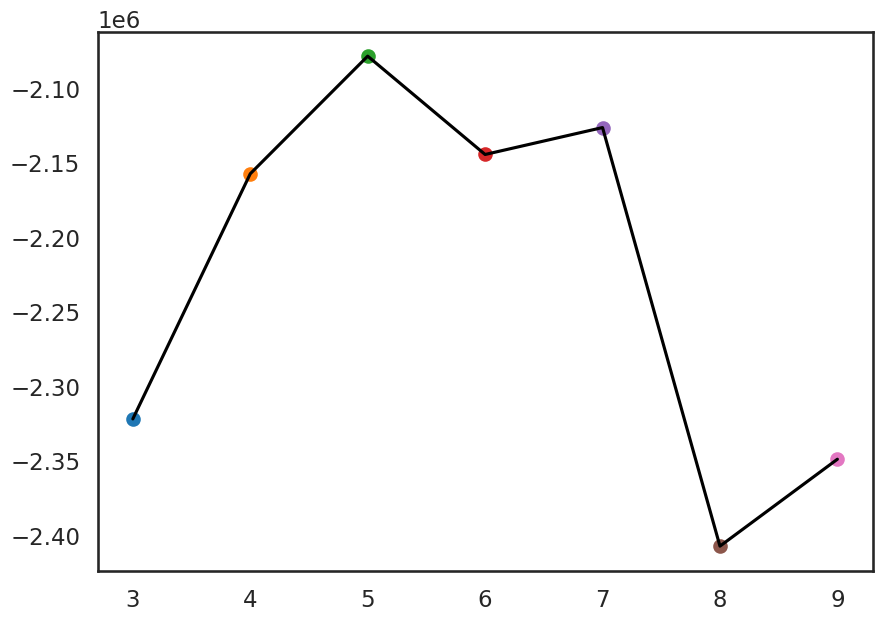

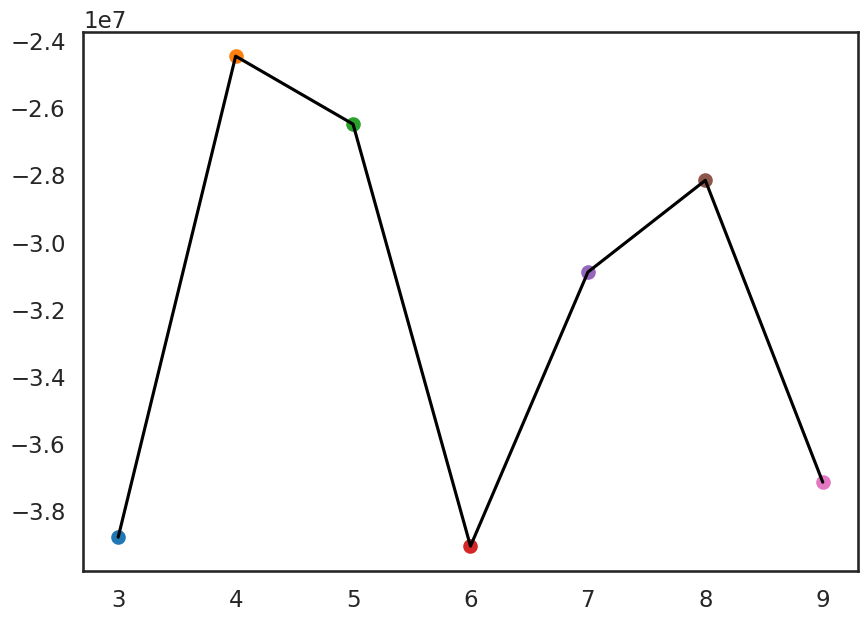

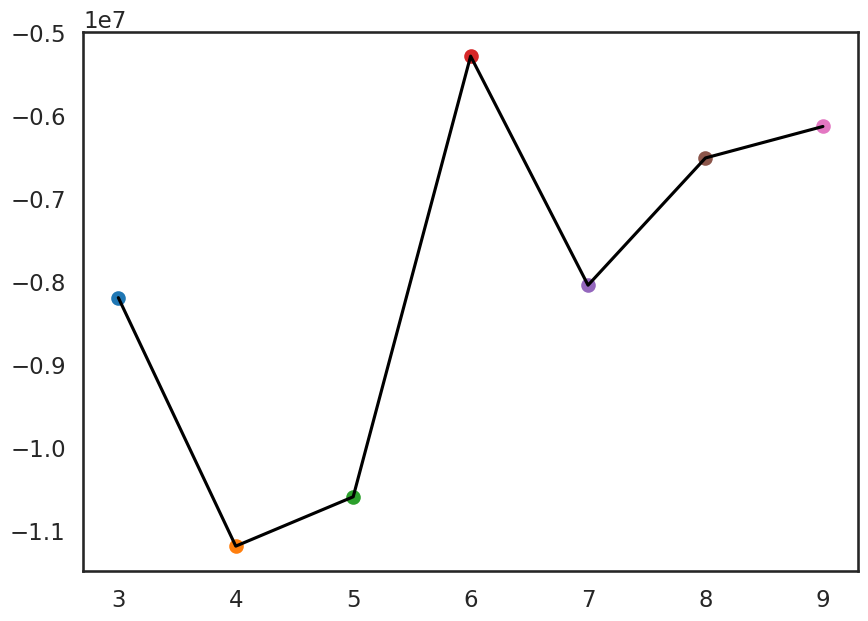

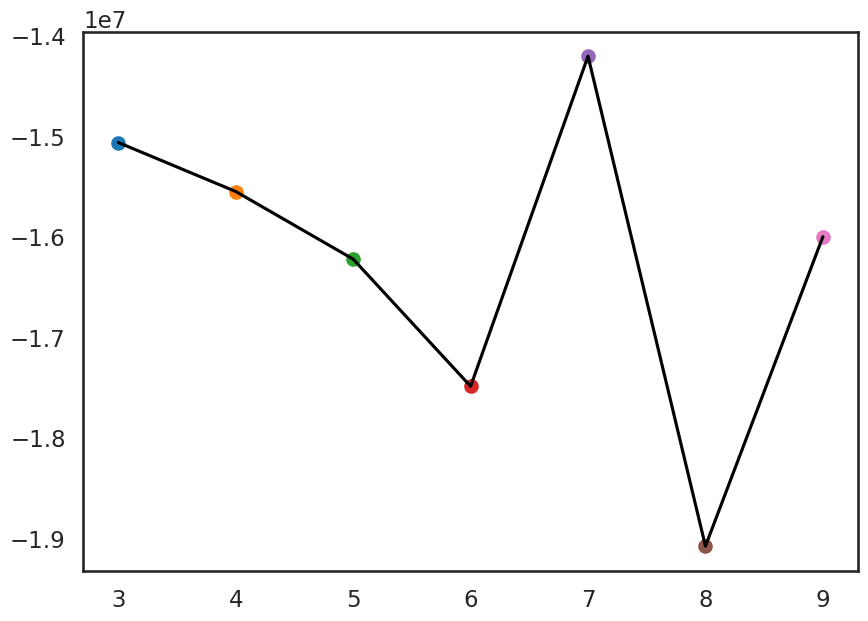

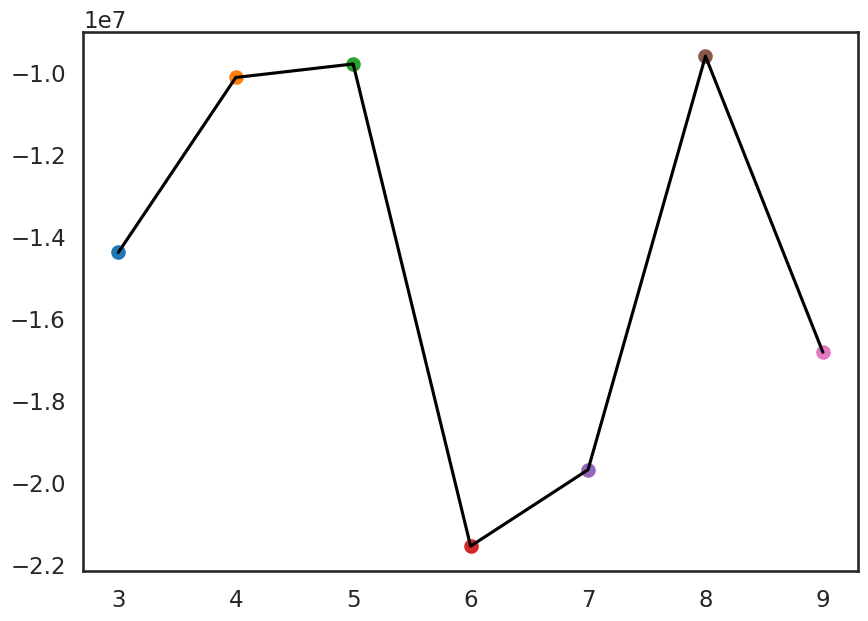

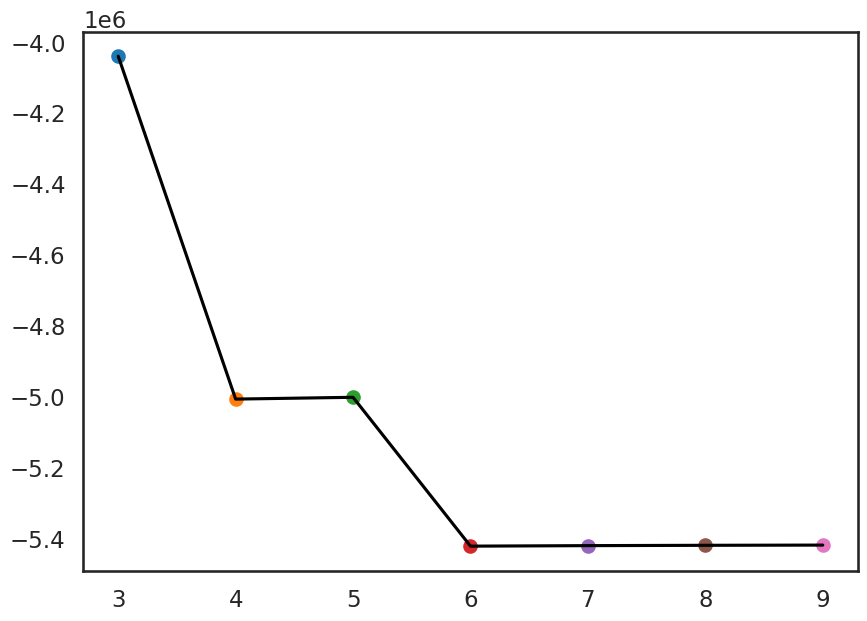

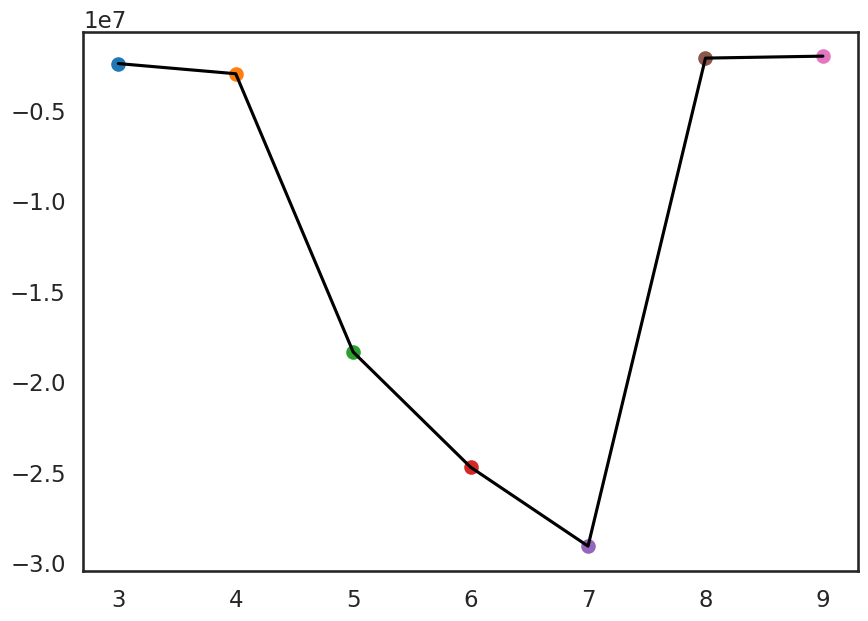

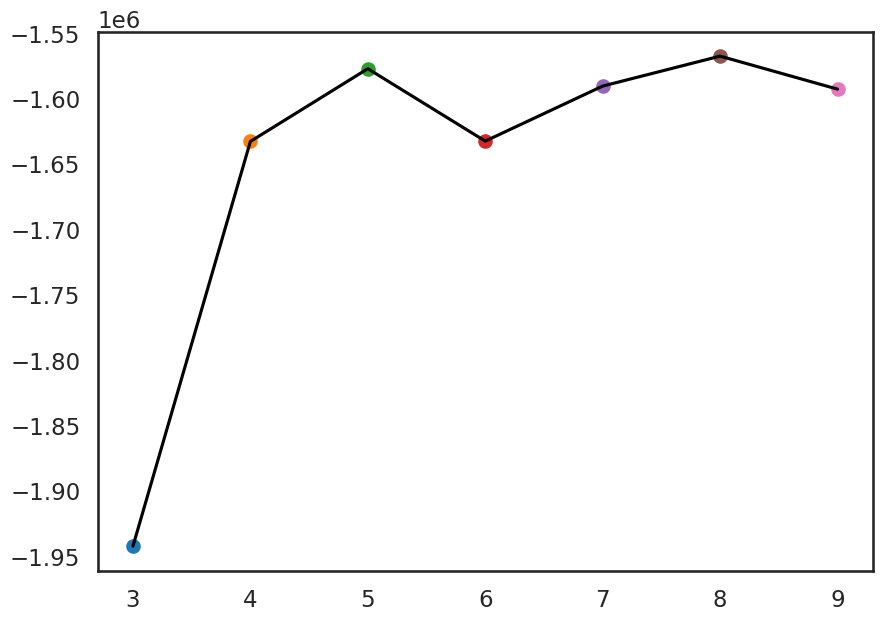

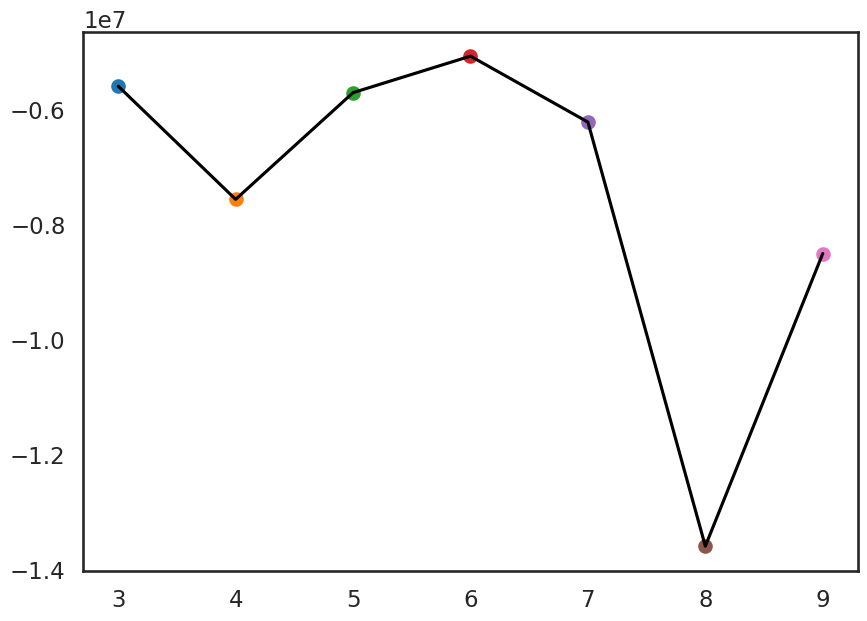

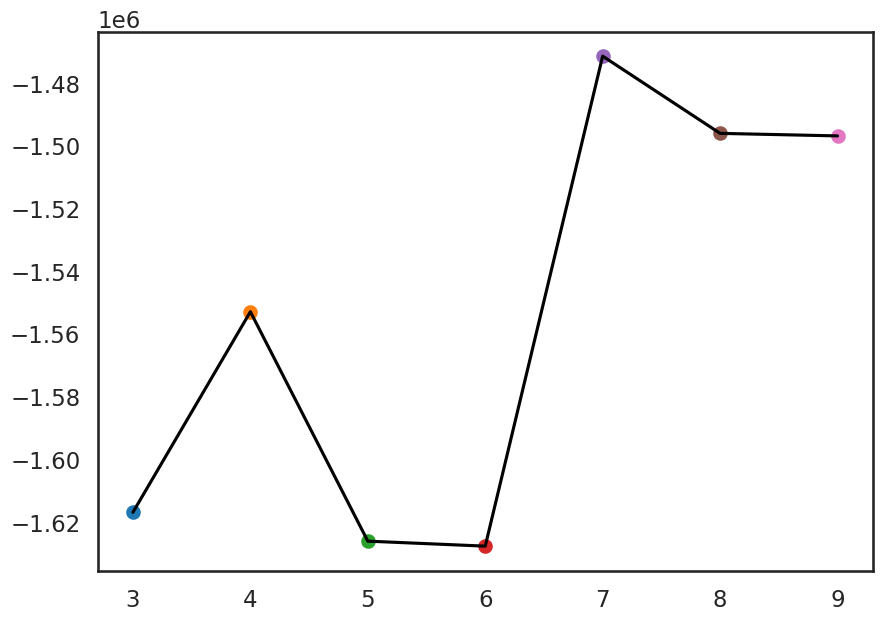

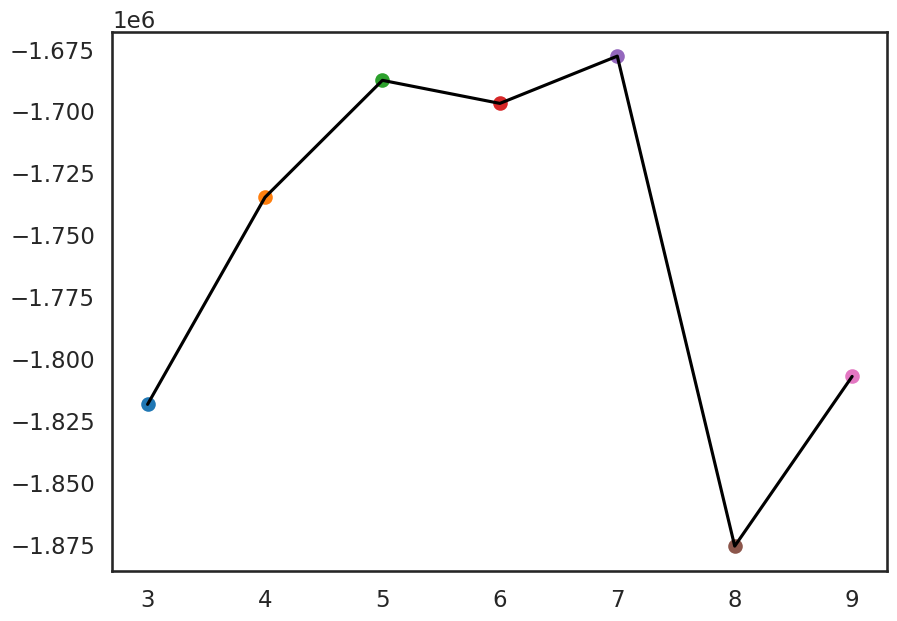

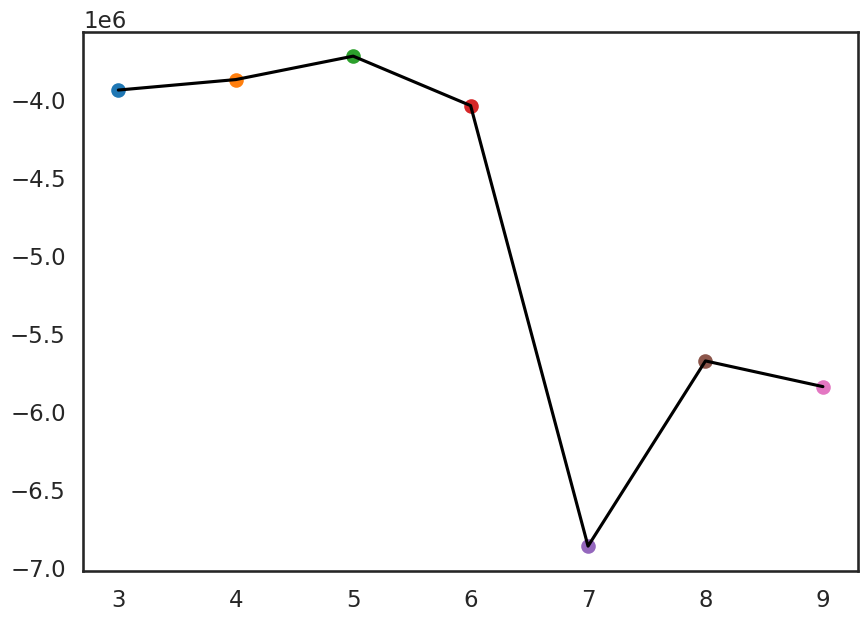

In [7]:
S = np.load('SumOfLogLikelihood.npy', allow_pickle=True)

s = np.mean(S, axis = 1)
for number in range(0, 12):
    fig, axs = plt.subplots(1,1,figsize = (10,7))
    for n, ll in zip(range(3,10,1), S):
        nn = [n for i in range(len(ll))]
        axs.scatter(nn[number], ll[number])
    axs.plot(np.arange(3,10,1), np.array(S).T[number], color = 'black')
    axs.set_xticks(np.arange(3,10,1))
    plt.show()

In [8]:
np.array(S).T[7]

array([-1942288.44767559, -1632784.88304996, -1577134.80559418,
       -1632520.0330389 , -1590433.78625784, -1567531.68459269,
       -1592771.60813552])

### Determining Model Session

In [ ]:
# 0, LL_mean = -215,7353.0
# 1, LL_mean = -2446,6969.0
# 2, LL_mean = -1122,1029.0
# 3, LL_mean = -1556,2783.0
# 4, LL_mean = -1011,3747.0
# 5, LL_mean = -500,7014.0
# 6, LL_mean = -298,6088.0
# 7, LL_mean = -163,4606.0
# 8, LL_mean = -537,1325.0
# 9, LL_mean = -155,2906.0
# 10, LL_mean = -173,5715.0
# 11, LL_mean = -387,0867.0

'''N = 4
feature = ['weight', 'smoothed_speed', 'smoothed_acceleration']
LL = []

for k in range(len(short_sessions)):
    title = 'ShortSession'+str(k)
    print(title)
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
    mouse_pos = DeleteRows(mouse_pos)
            
    obs = np.array(mouse_pos[feature])
    hmm, states, transition_mat, lls = FitHMM(obs, num_states = N, n_iters = 50)
    ll = []

    for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
        title = 'ShortSession'+str(j)
        mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
        mouse_pos = DeleteRows(mouse_pos)
            
        obs = np.array(mouse_pos[feature])
        states = hmm.most_likely_states(obs)
            
        ll.append(hmm.log_likelihood(obs))
        
    LL.append(ll)

fig, axs = plt.subplots(1, 1, figsize = (6,5))
sns.heatmap(LL, ax = axs, cmap = 'YlGnBu', square=True)
plt.show()'''

### Fit the model using one session: session 7

ShortSession7


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

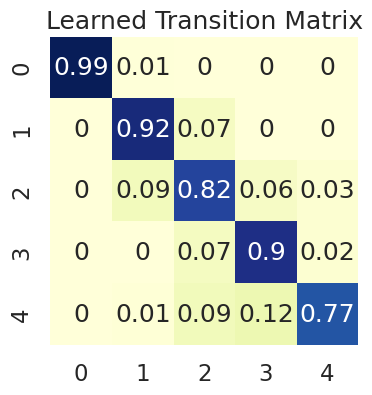

In [7]:
N = 5
feature = ['weight', 'smoothed_speed', 'smoothed_acceleration']

title = 'ShortSession'+str(7)
print(title)
mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
mouse_pos = DeleteRows(mouse_pos)
        
obs = np.array(mouse_pos[feature])
hmm, states, transition_mat, lls = HMM.FitHMM(obs, num_states = N, n_iters = 50)

state_mean_speed = hmm.observations.params[0].T[1]
index = np.argsort(state_mean_speed, -1)
        
HMM.PlotTransition(transition_mat[index].T[index].T)

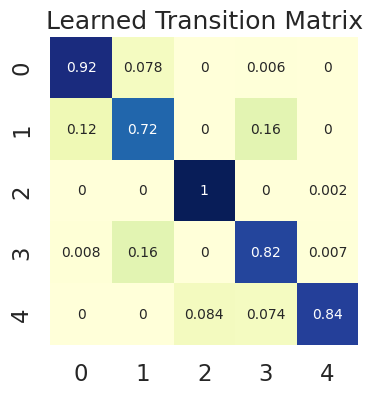

In [5]:
title = 'LongSession2'
transition_mat =  np.load(title+"Transition.npy", allow_pickle=True)
annot_array = np.array([[round(item, 3) for item in row] for row in transition_mat])
fig, axs = plt.subplots(1,1, figsize=(4, 4))
sns.heatmap(transition_mat, cmap='YlGnBu', ax = axs, square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
axs.set_title("Learned Transition Matrix")
plt.show()  

ShortSession0


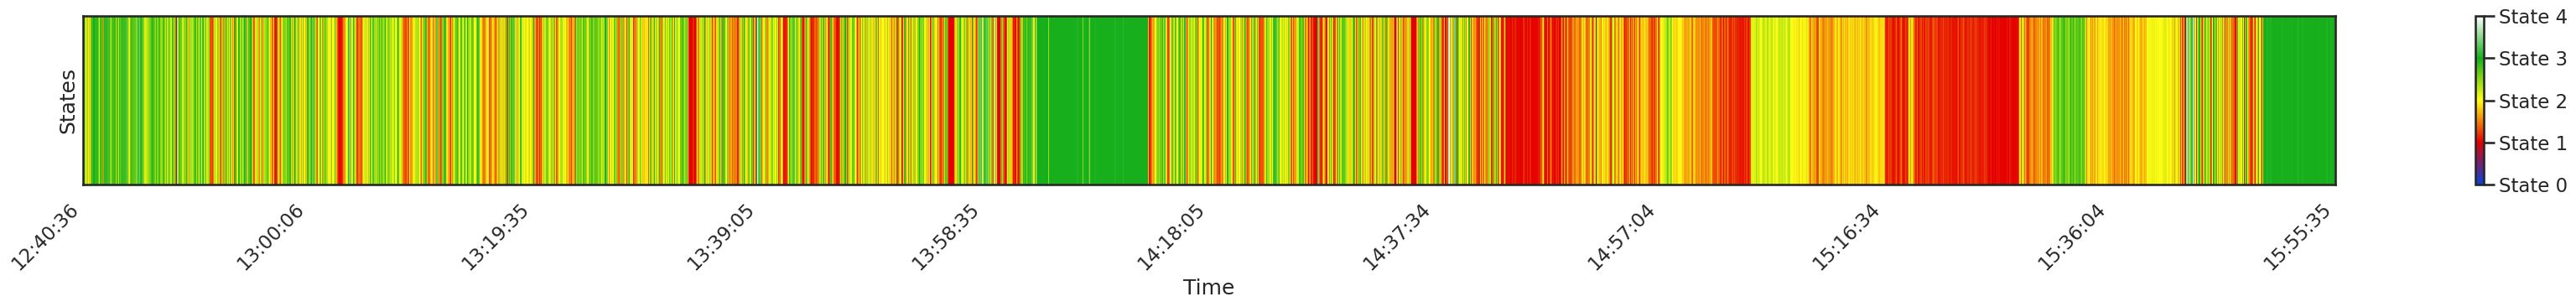

/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


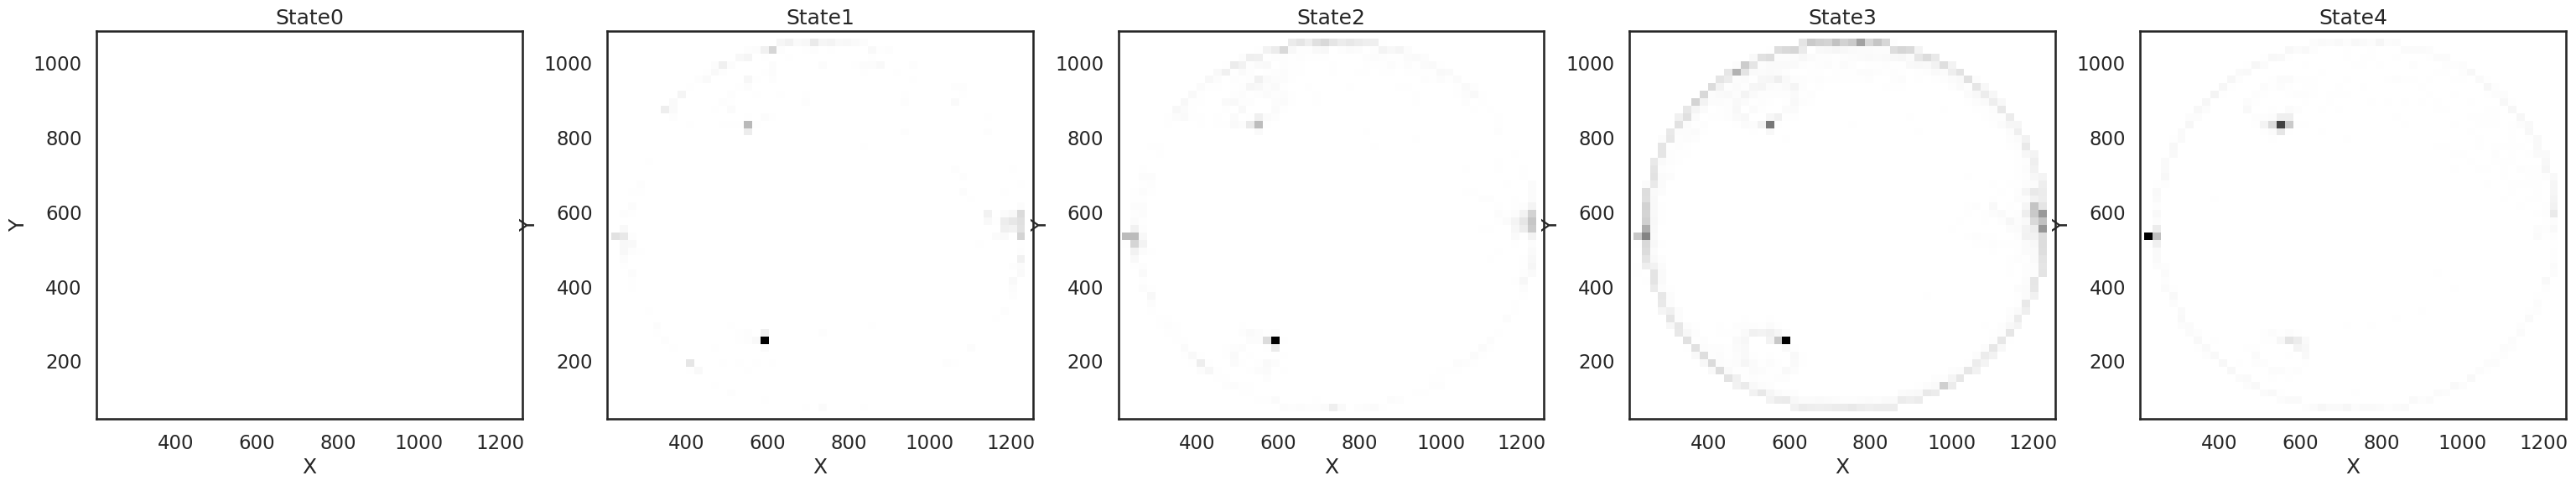

ShortSession1


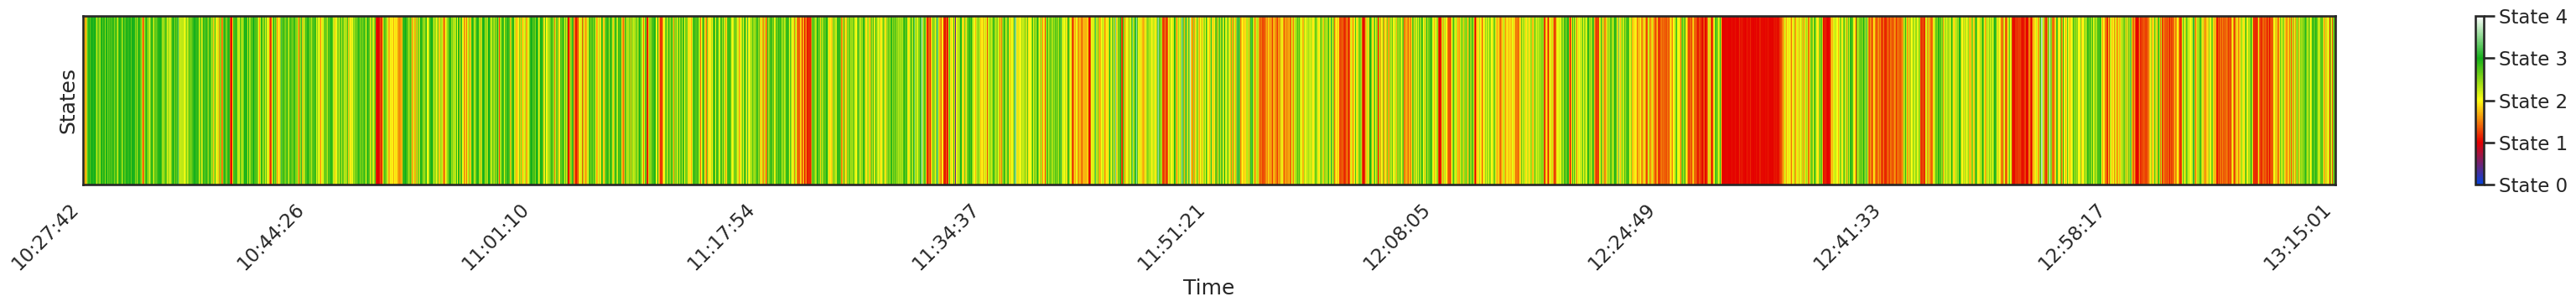

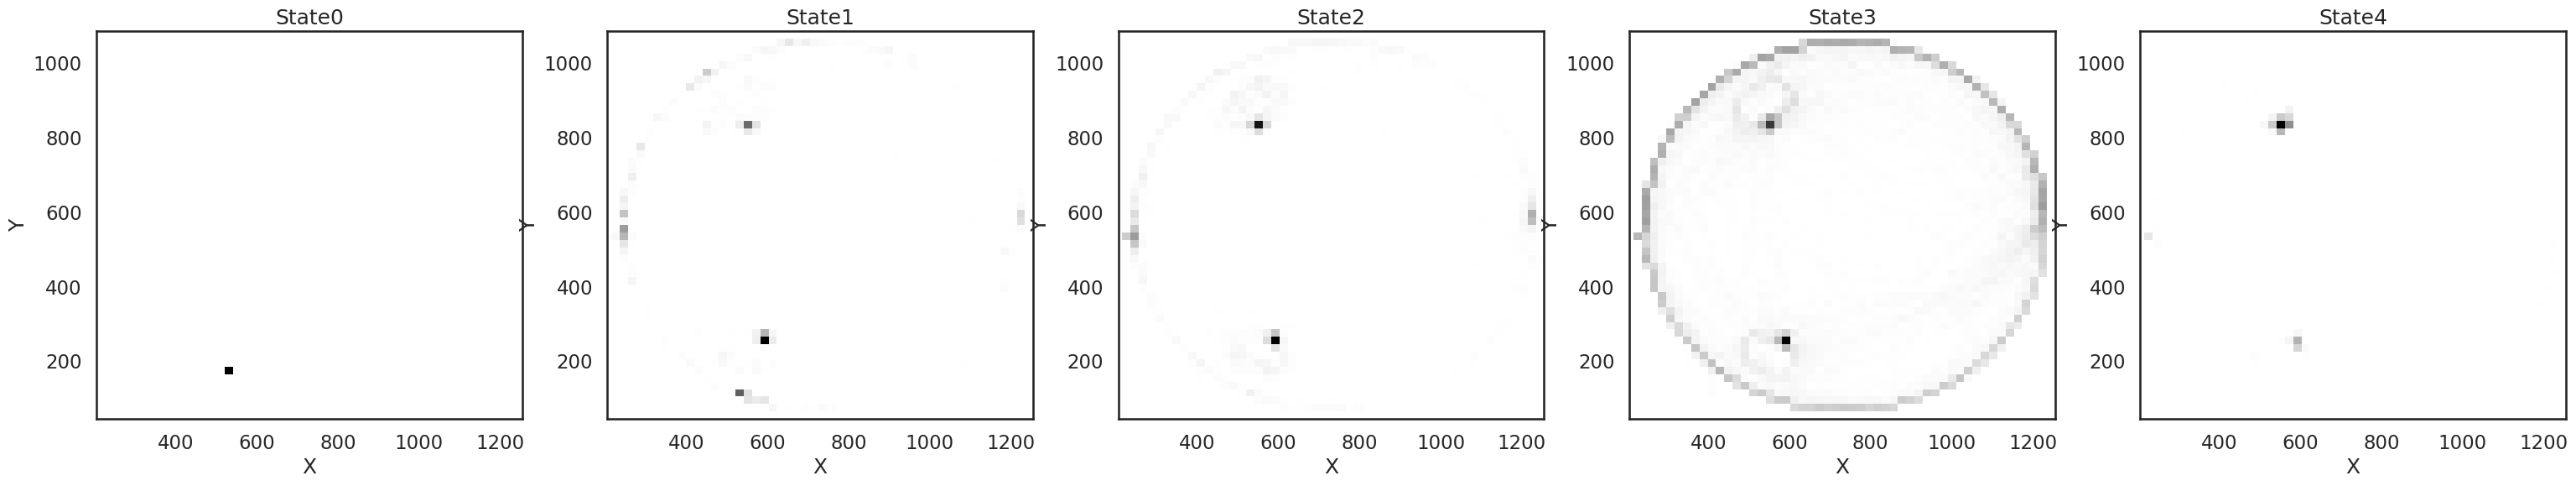

ShortSession2


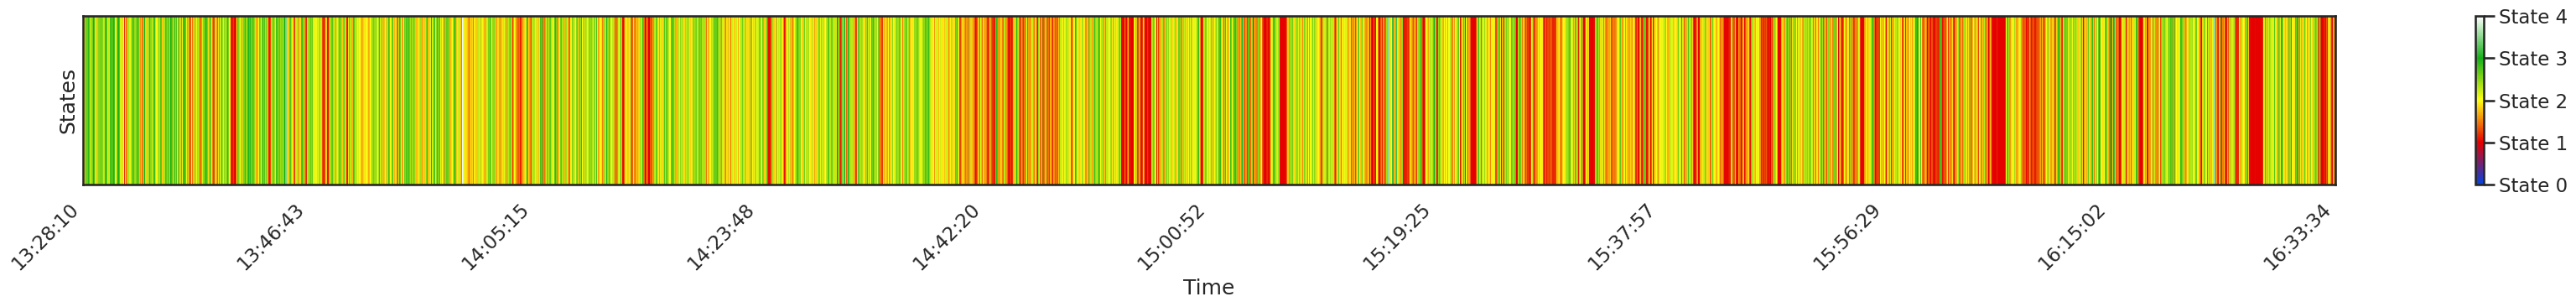

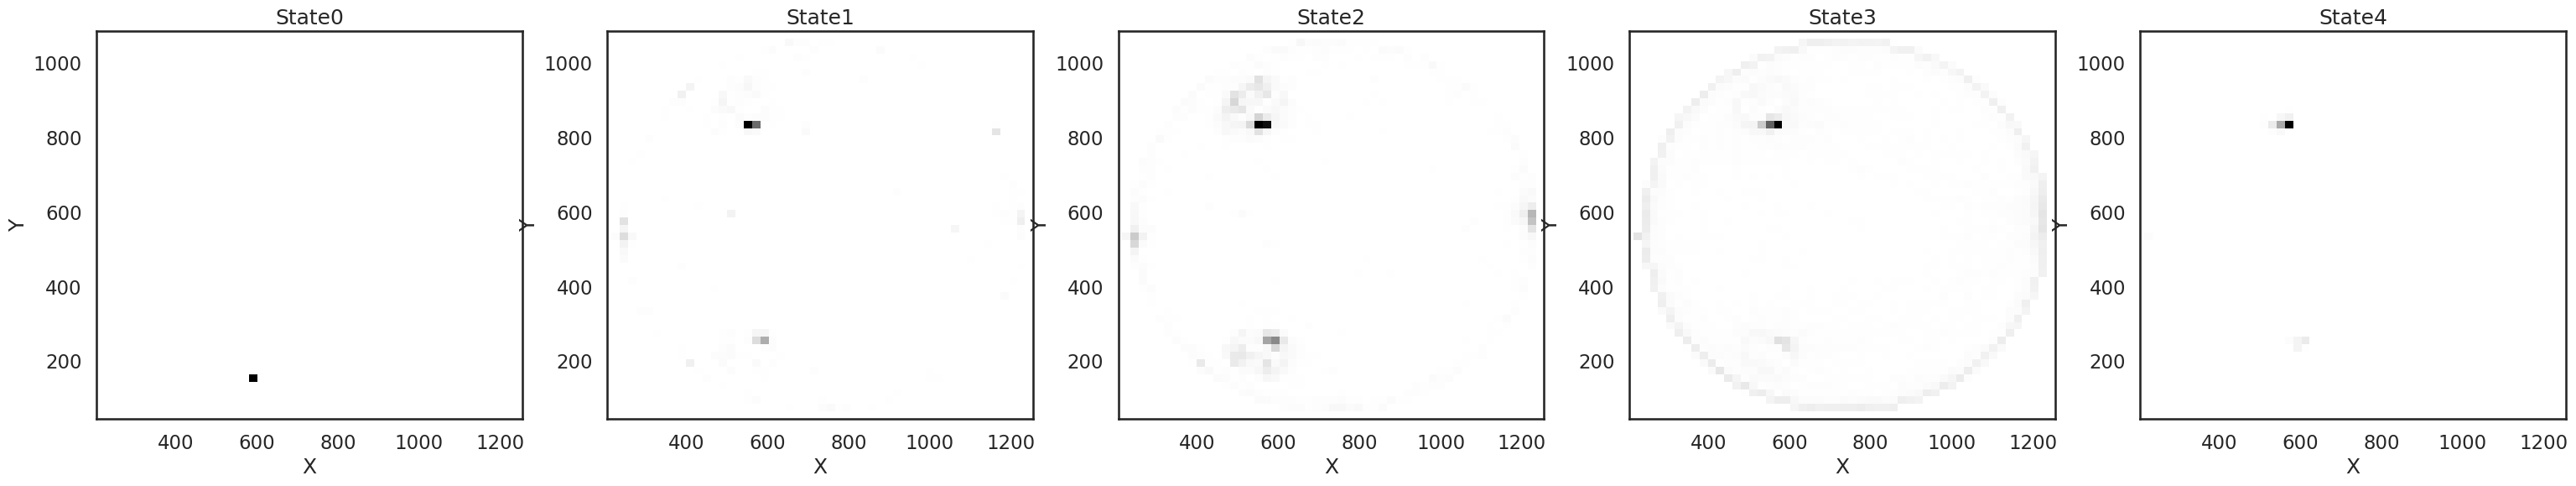

ShortSession3


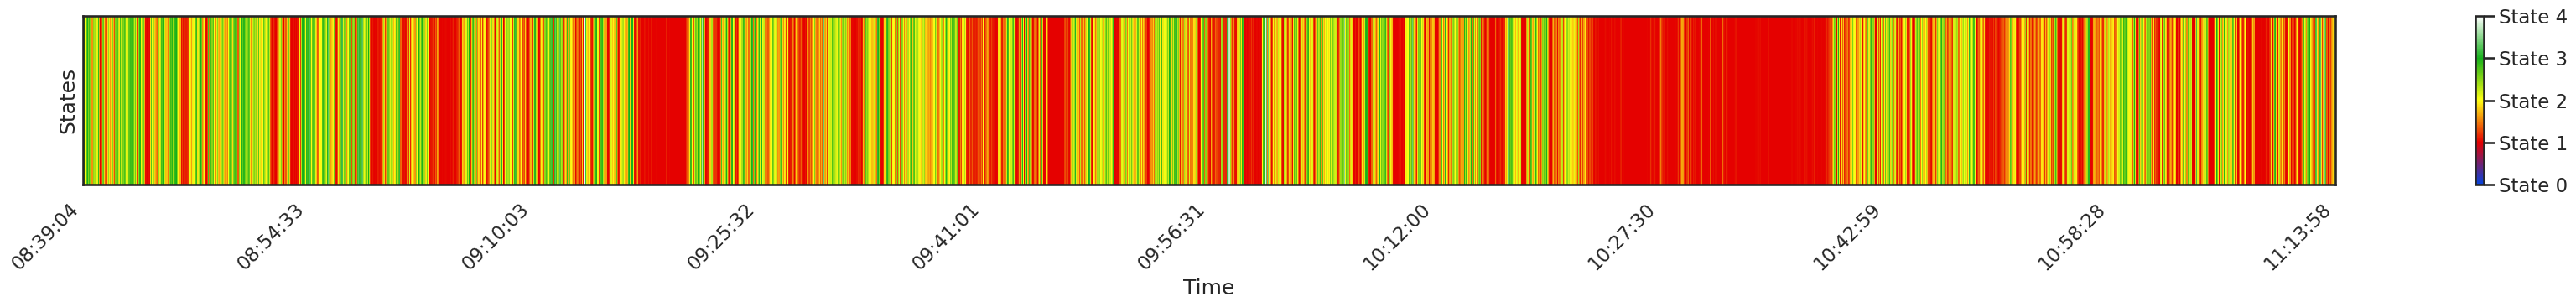

/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


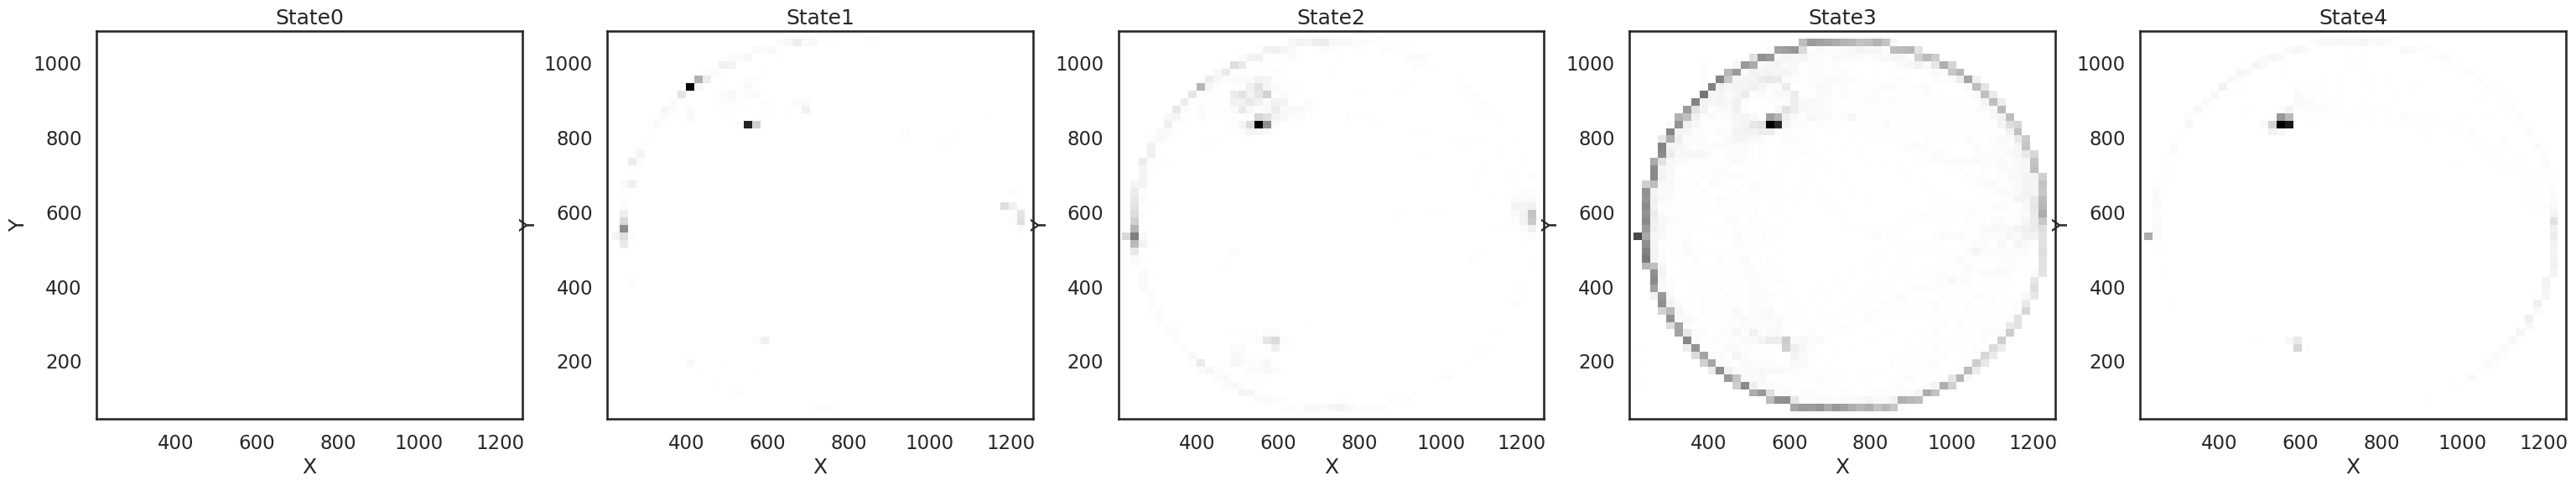

ShortSession4


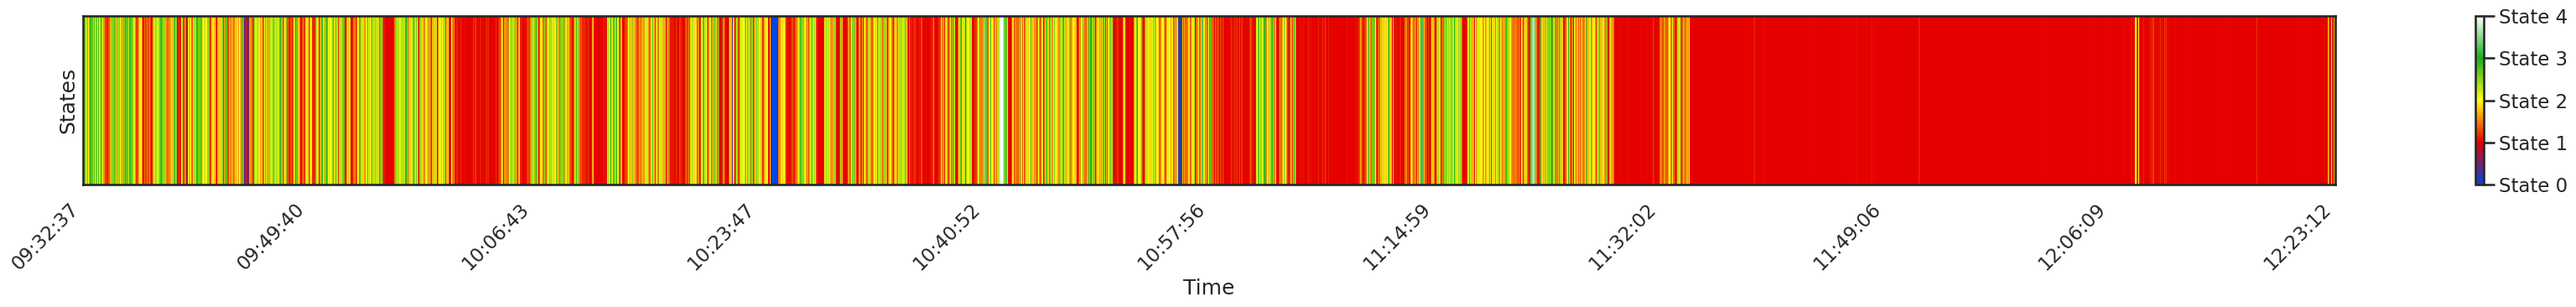

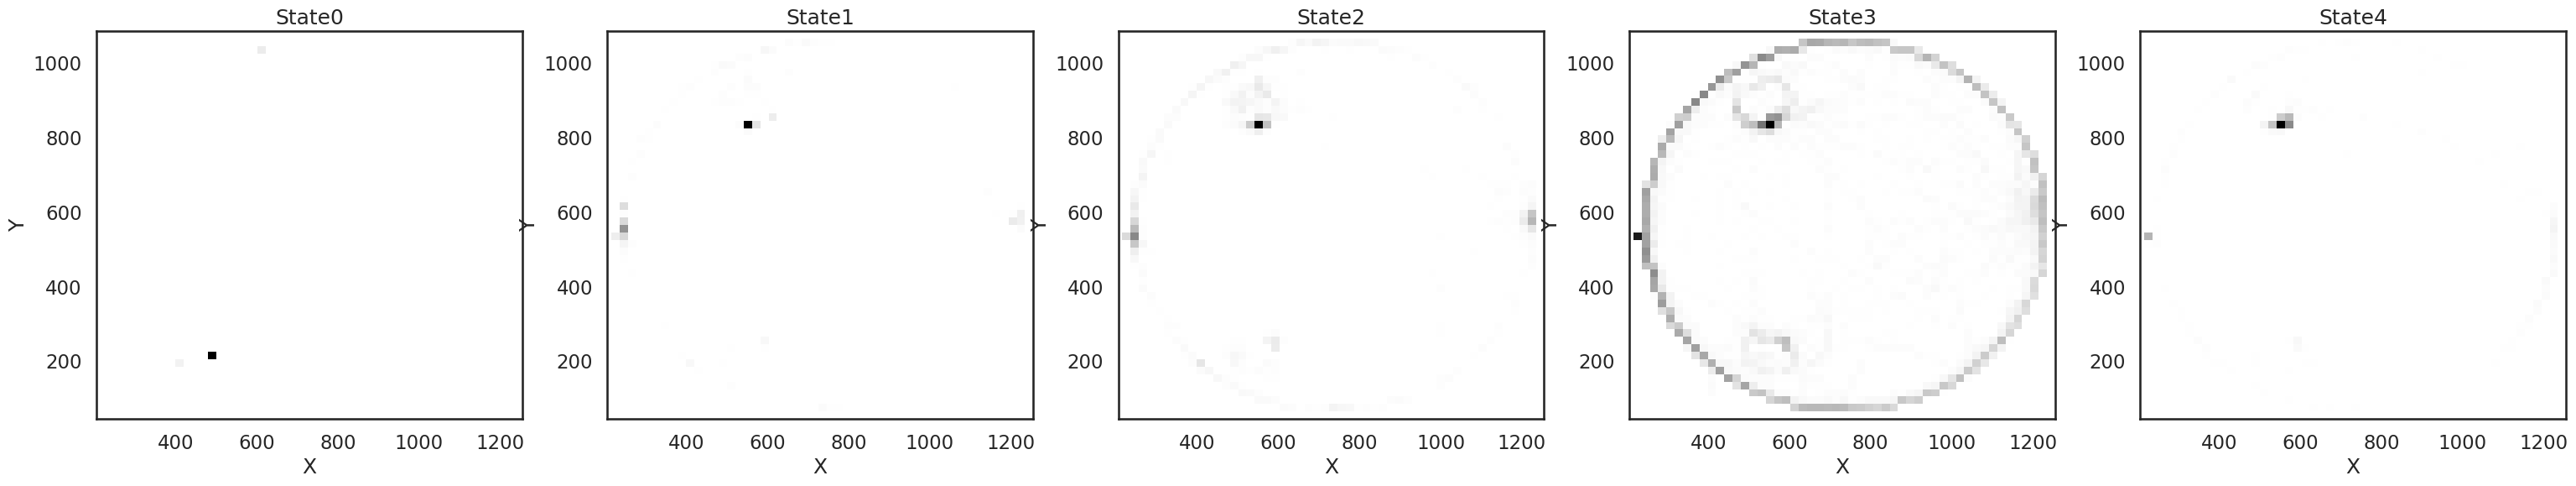

ShortSession5


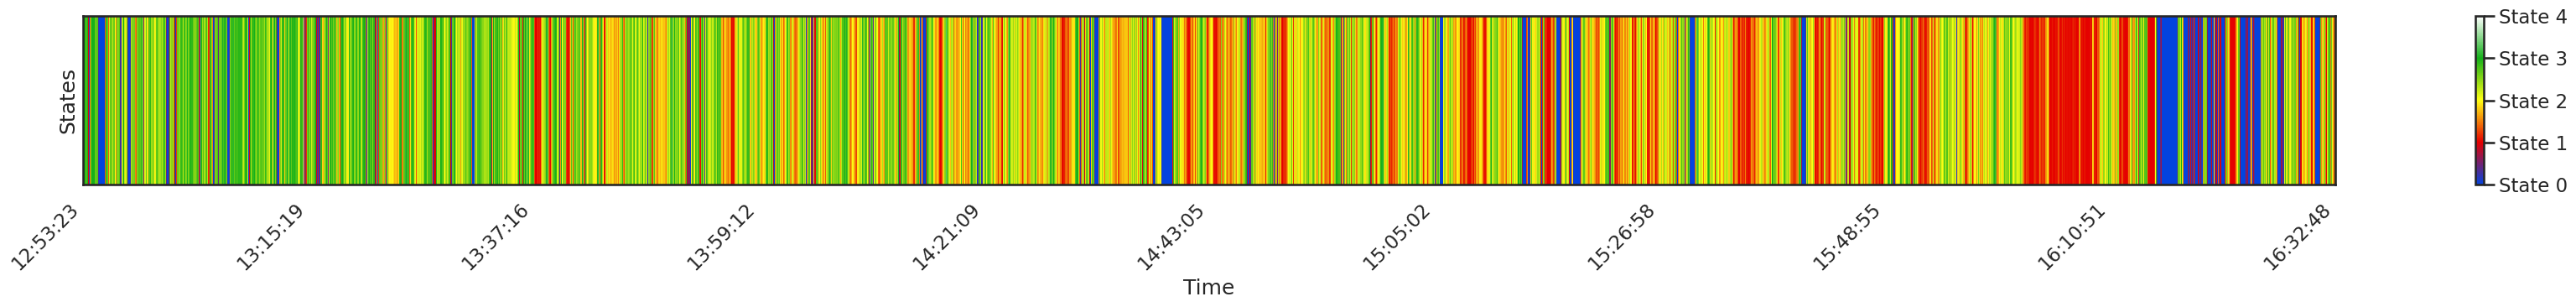

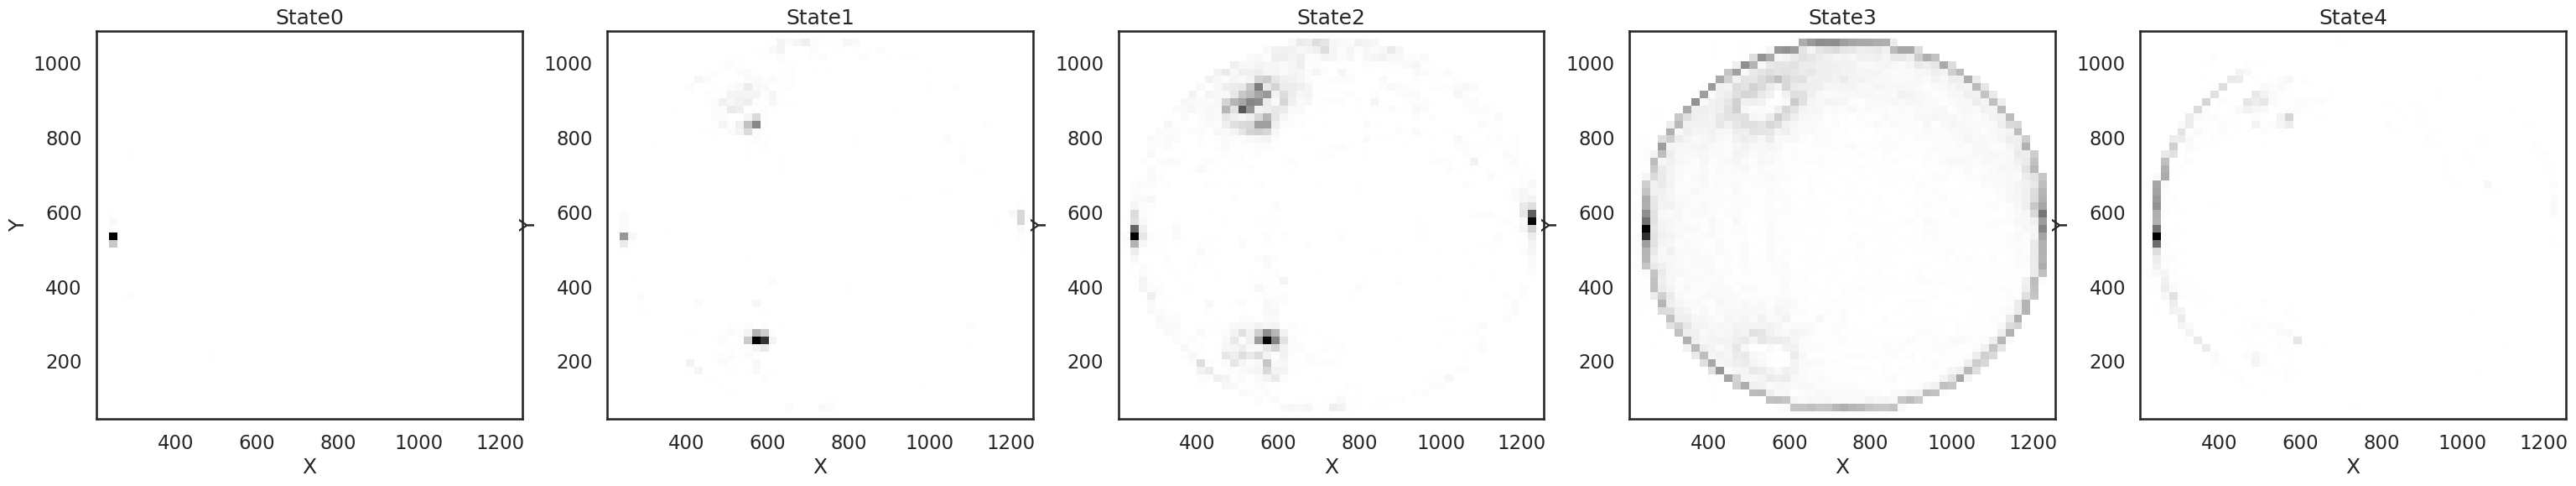

ShortSession6


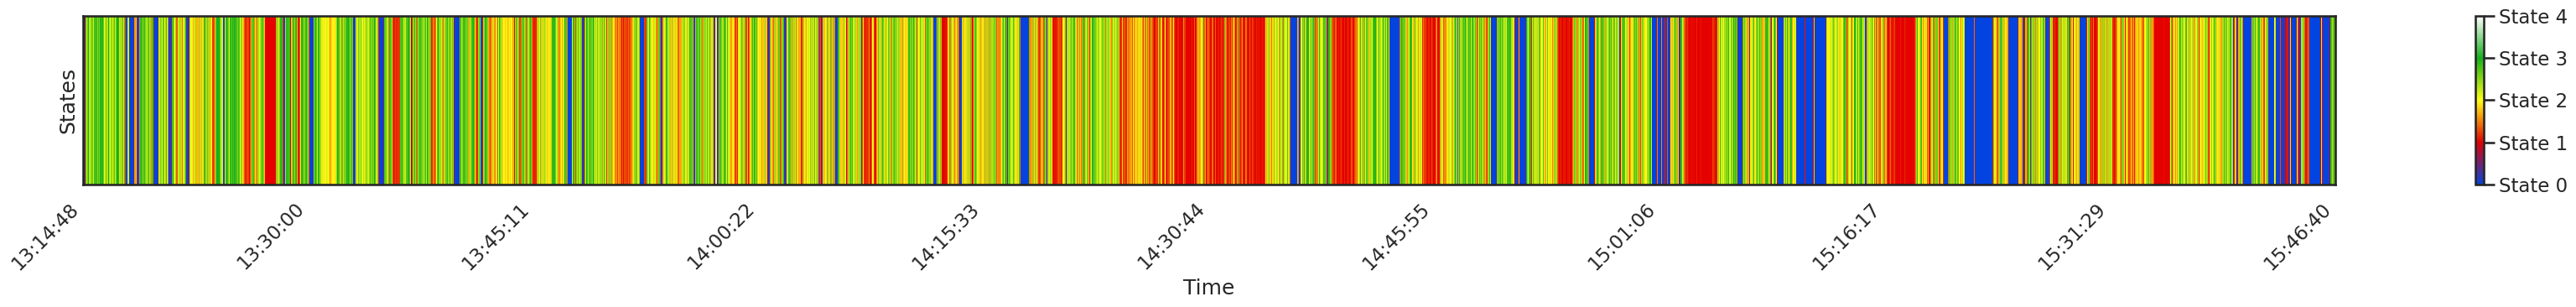

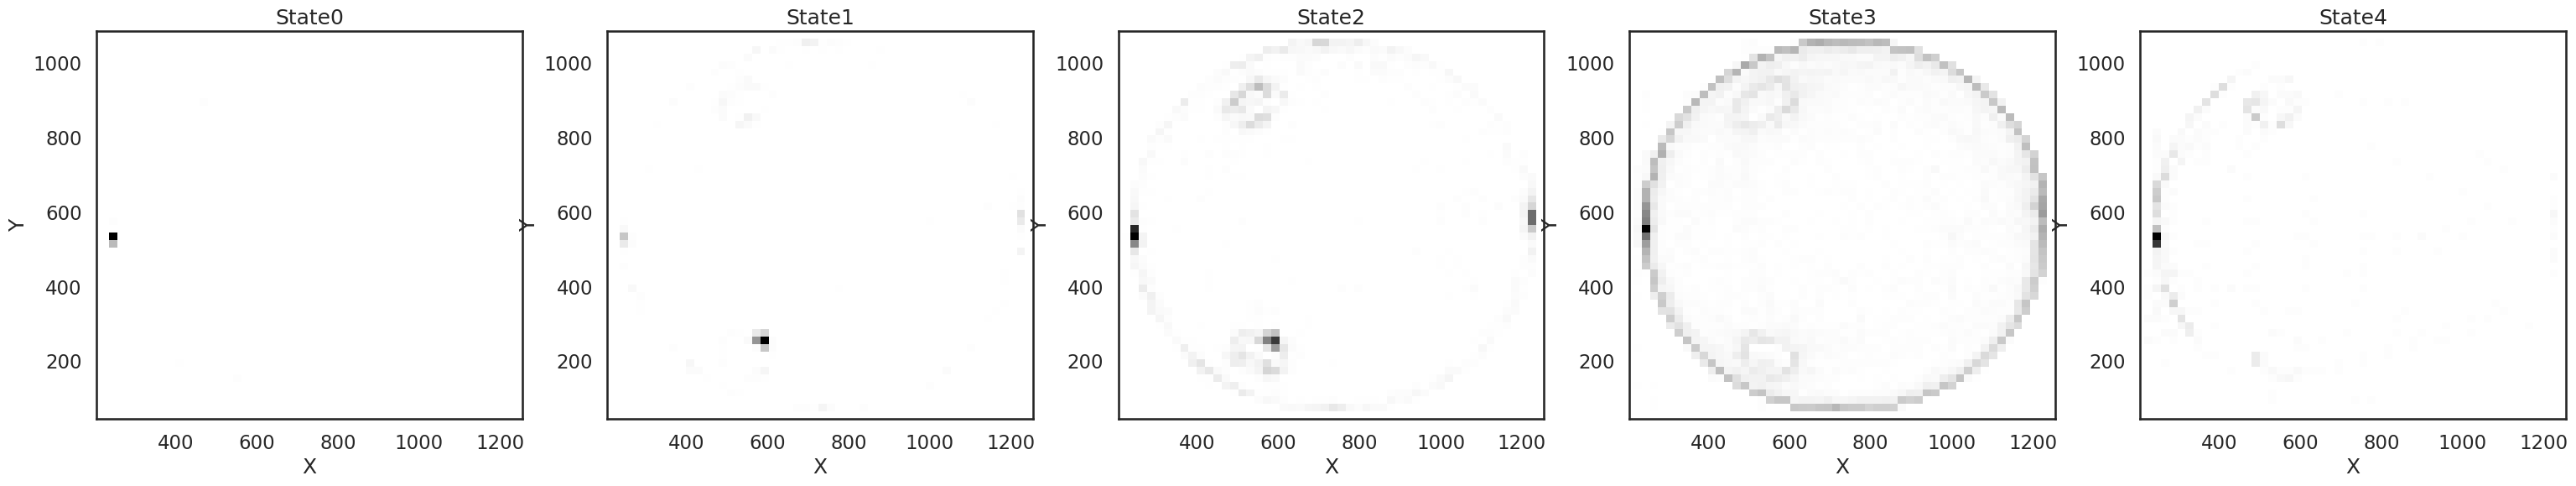

ShortSession7


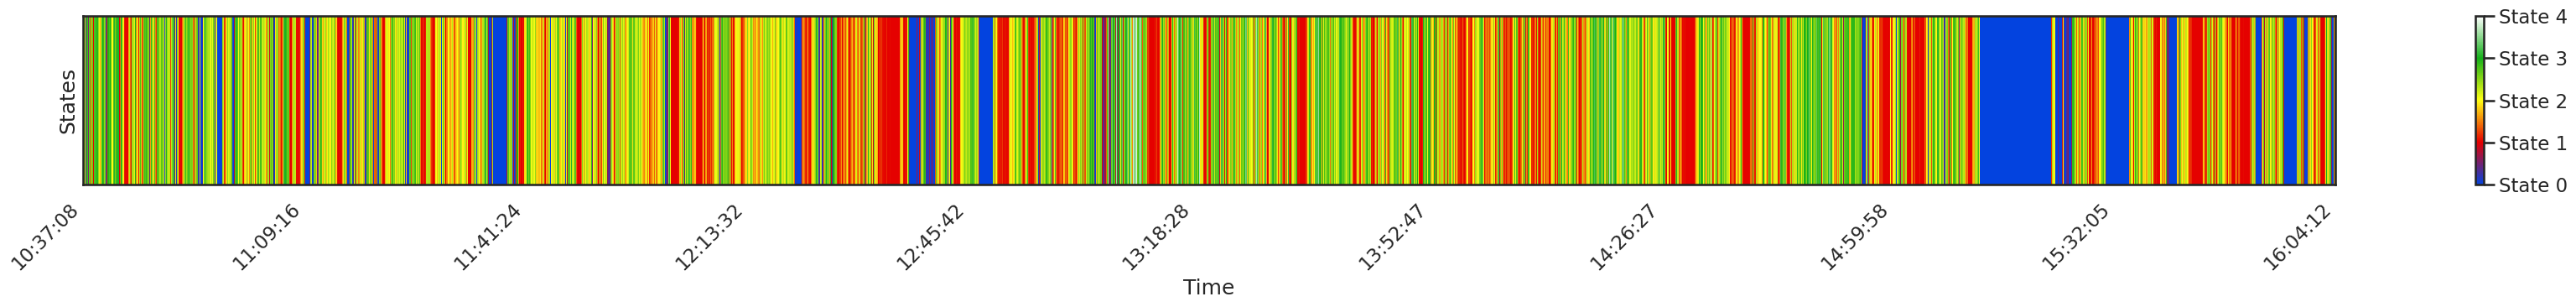

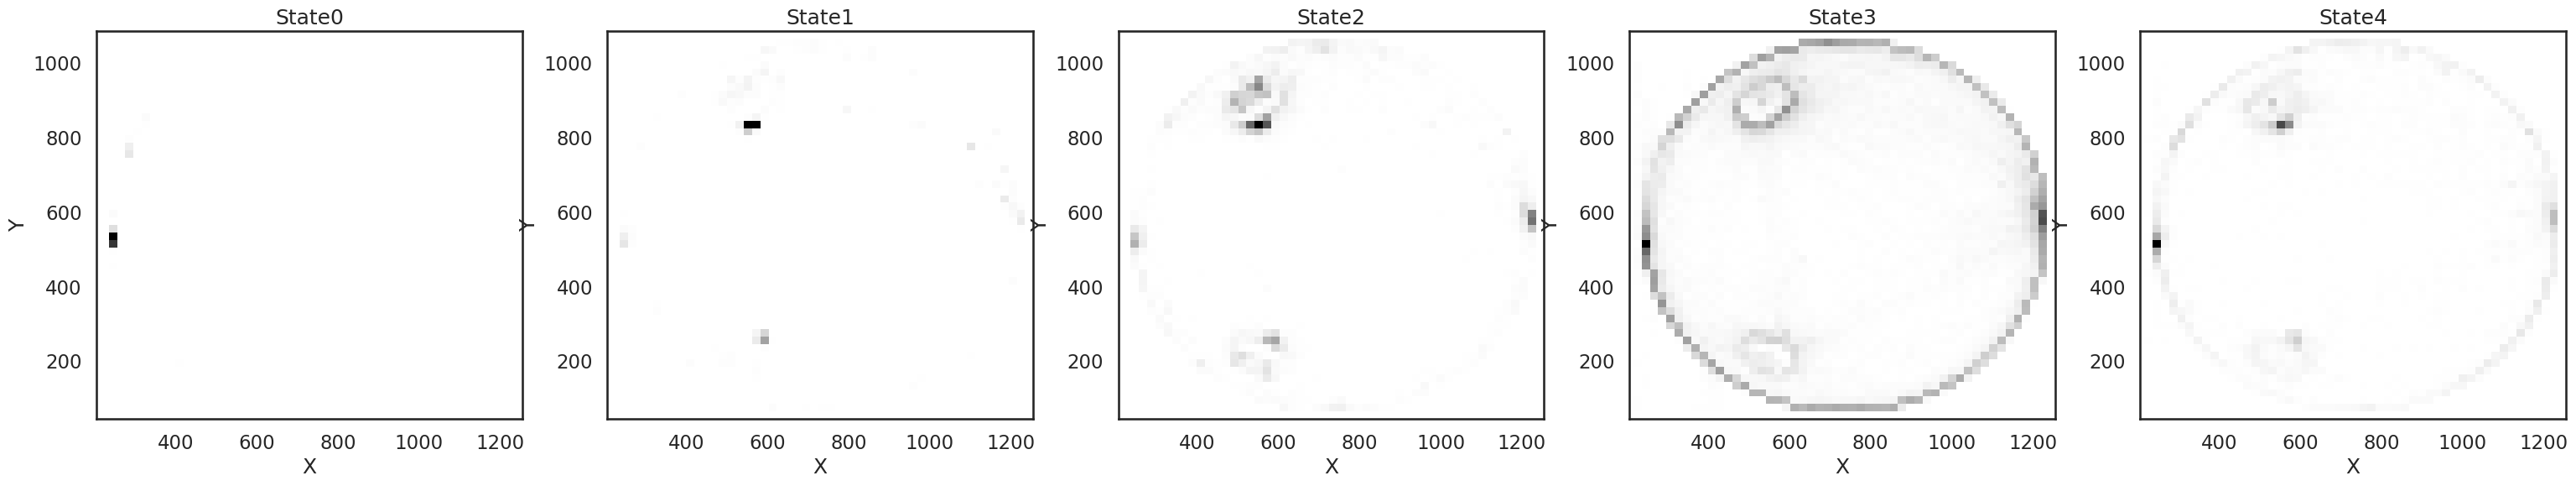

ShortSession8


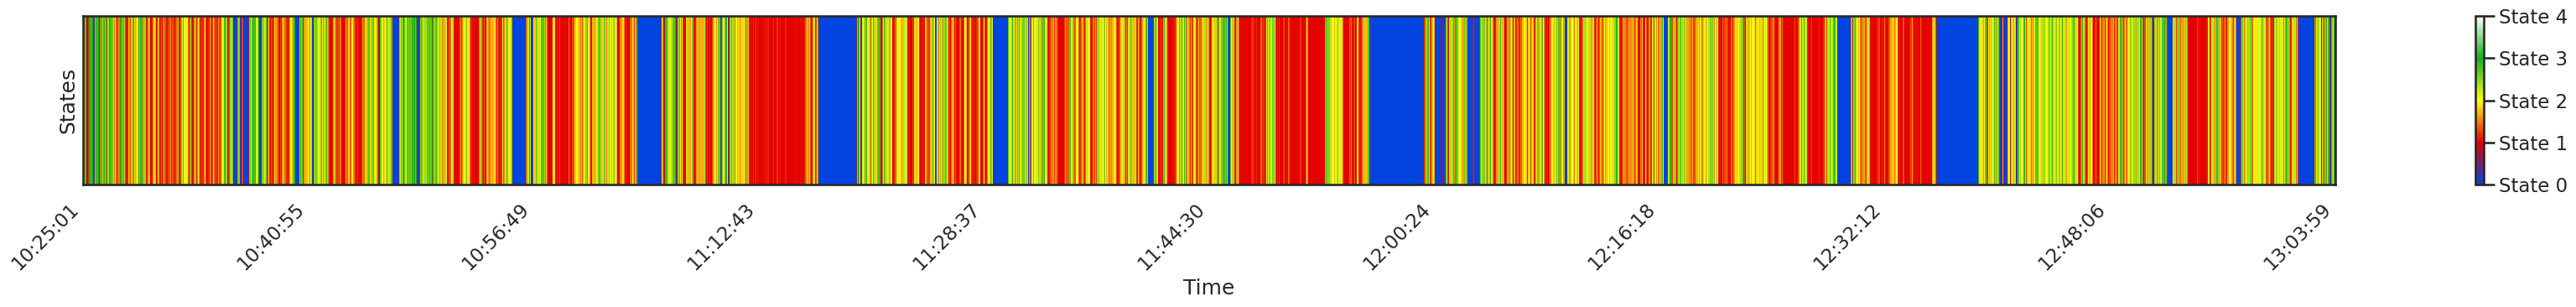

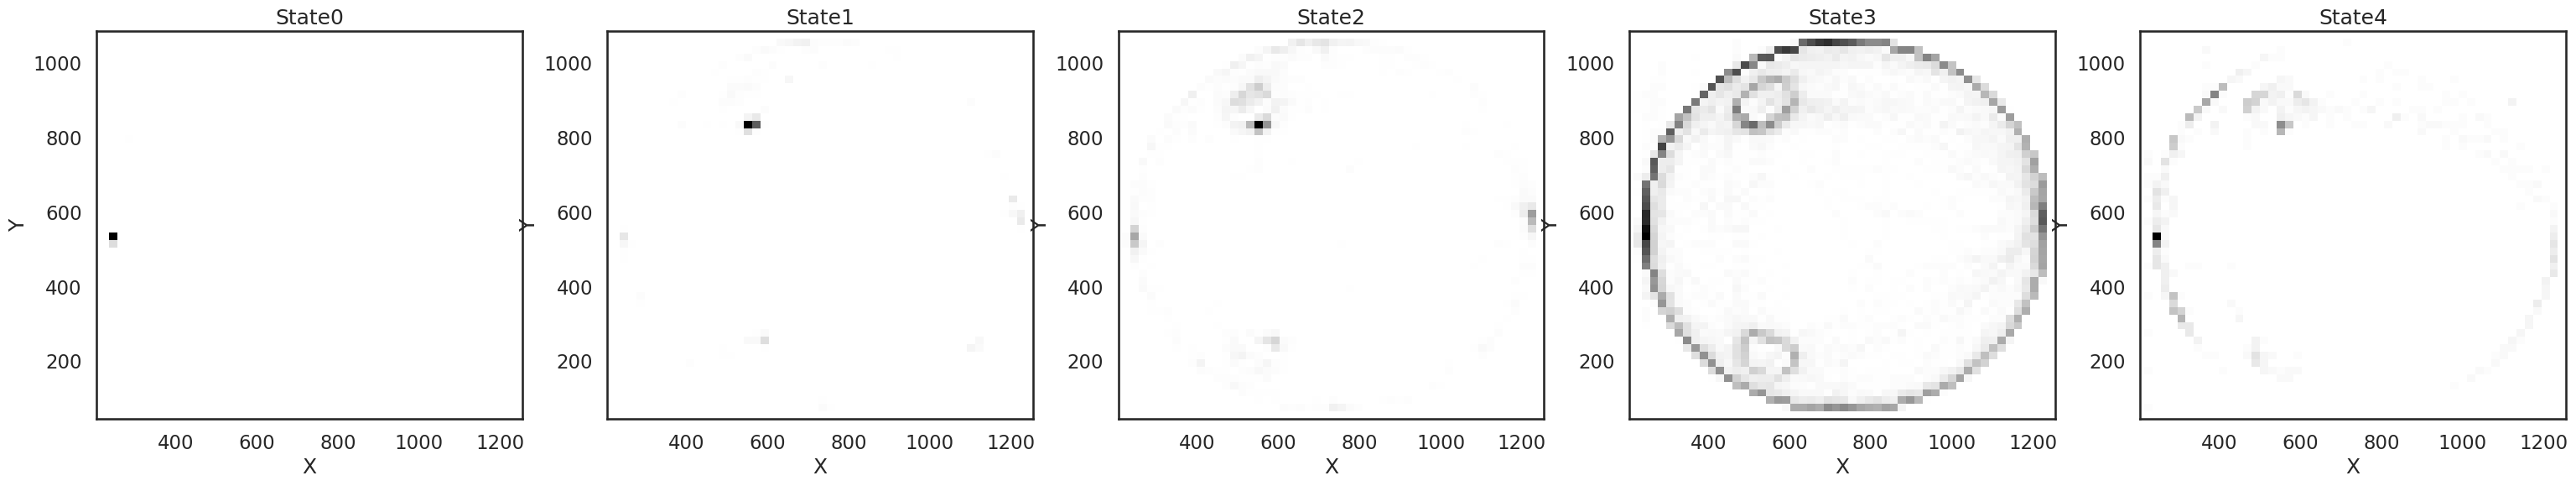

ShortSession9


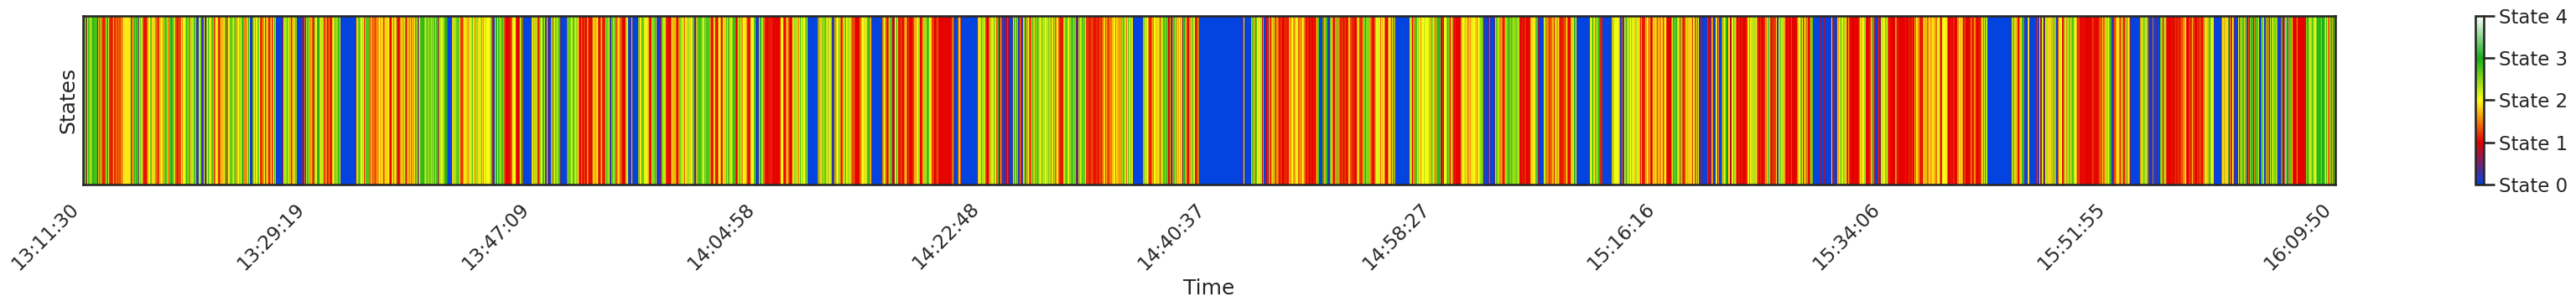

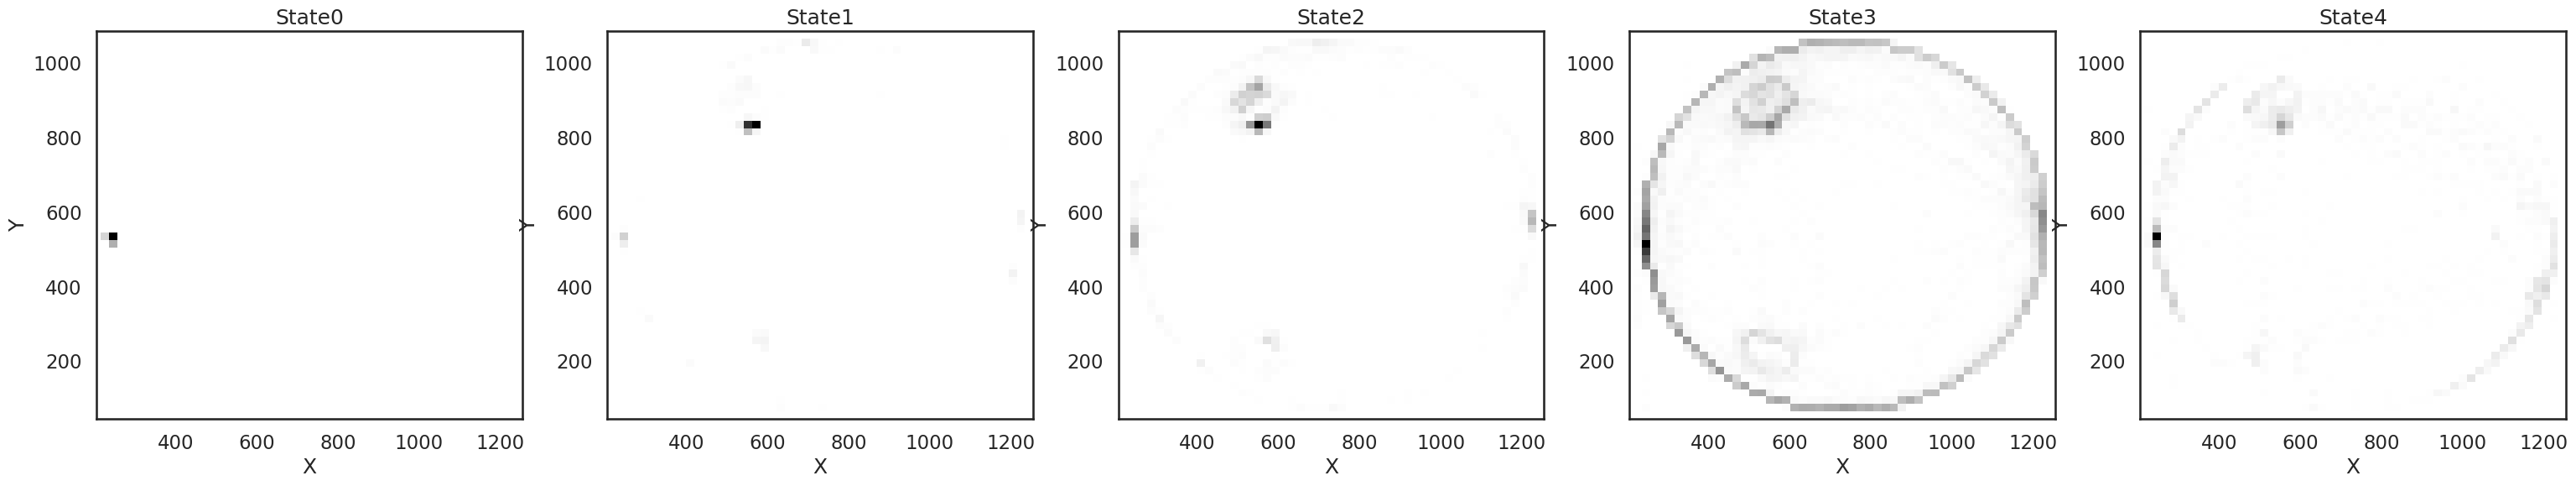

ShortSession10


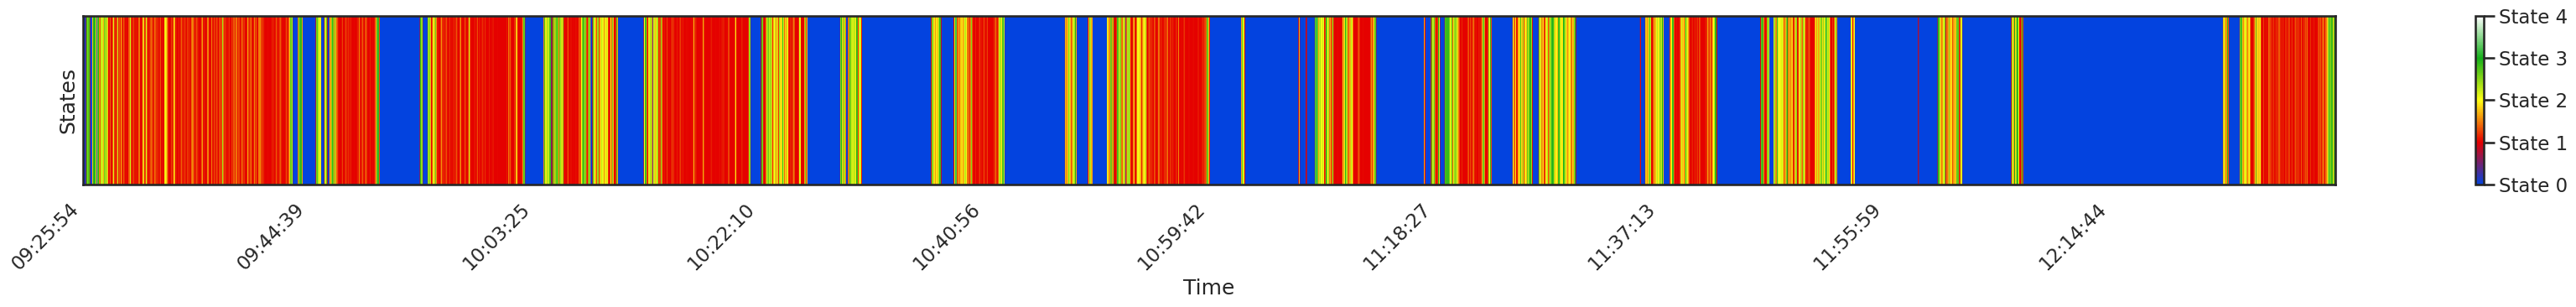

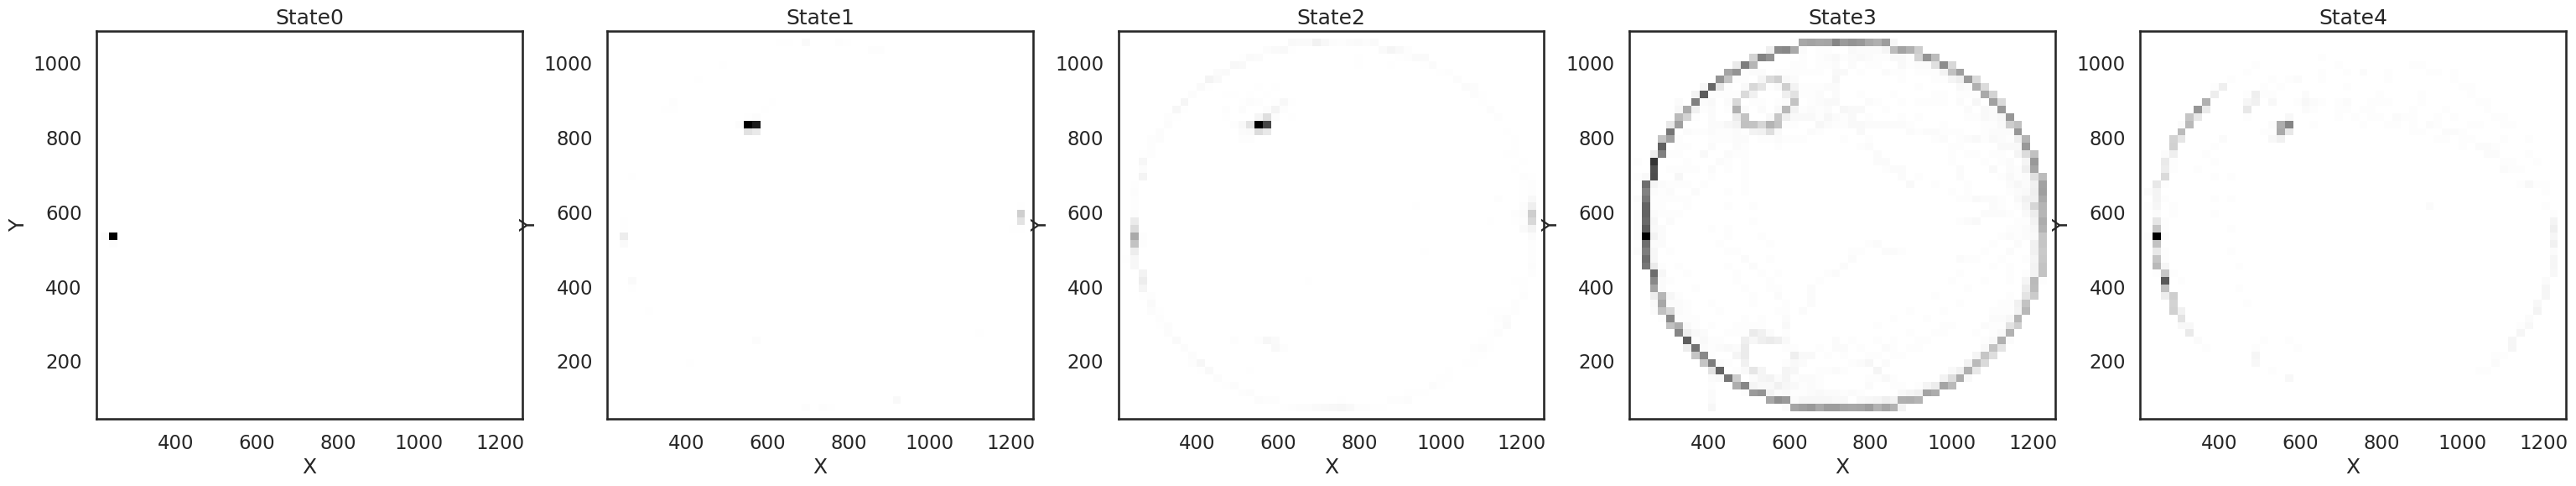

ShortSession11


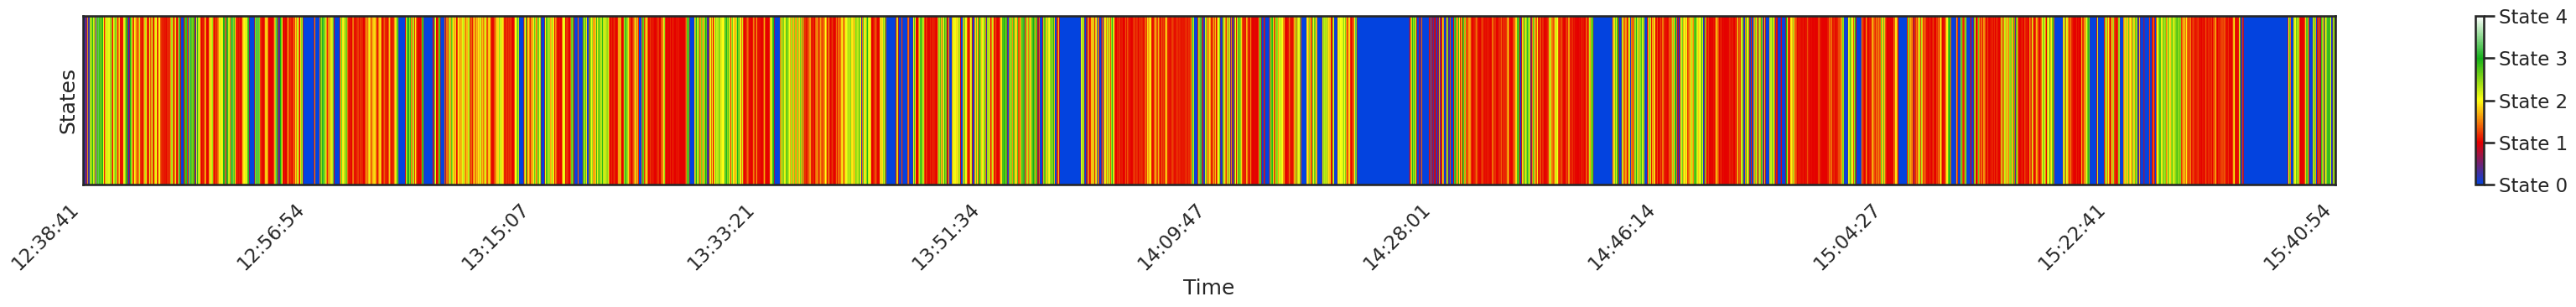

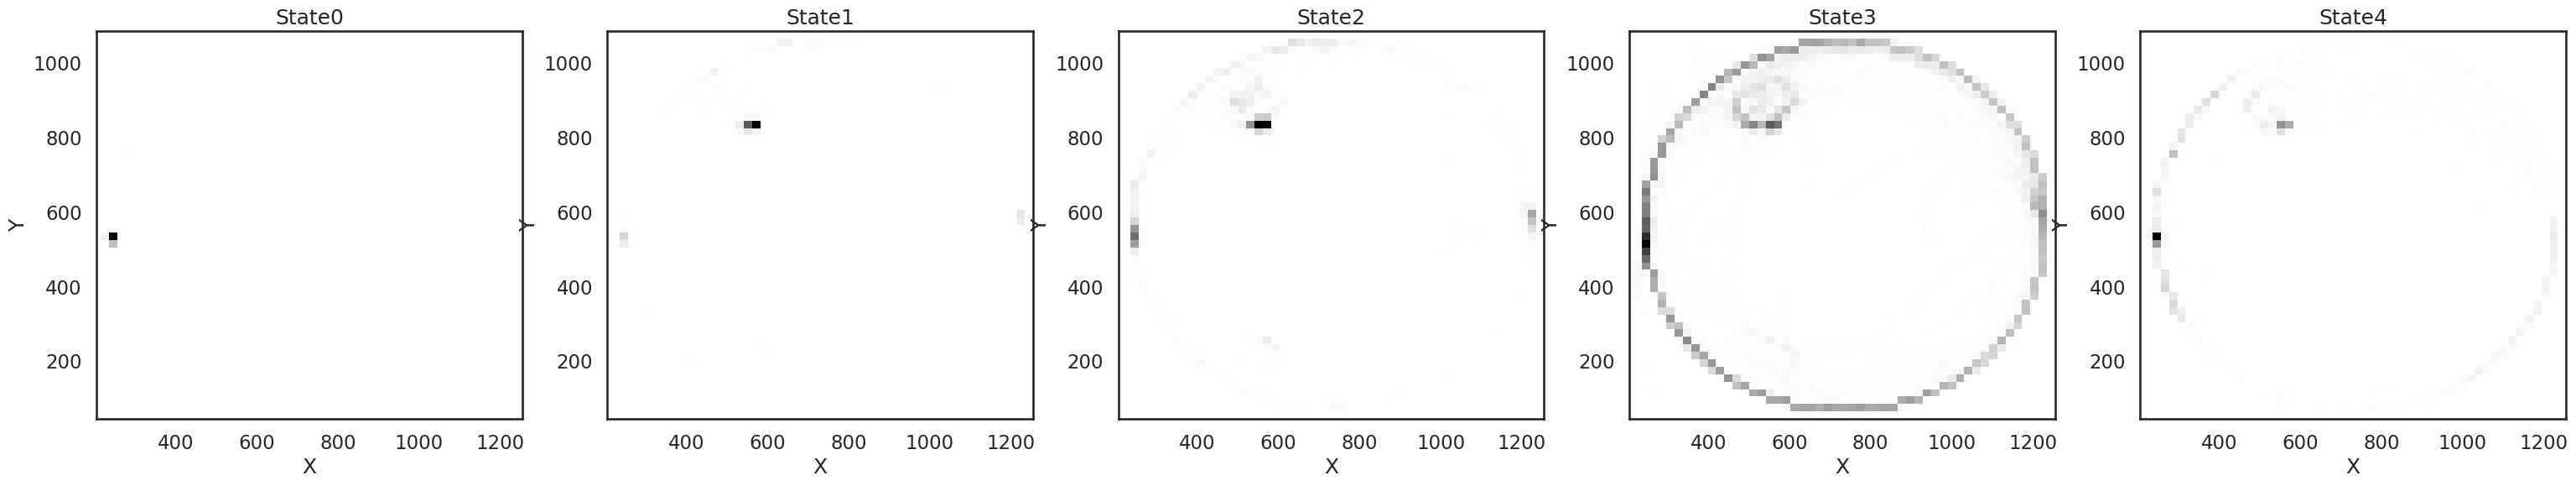

Overall: 


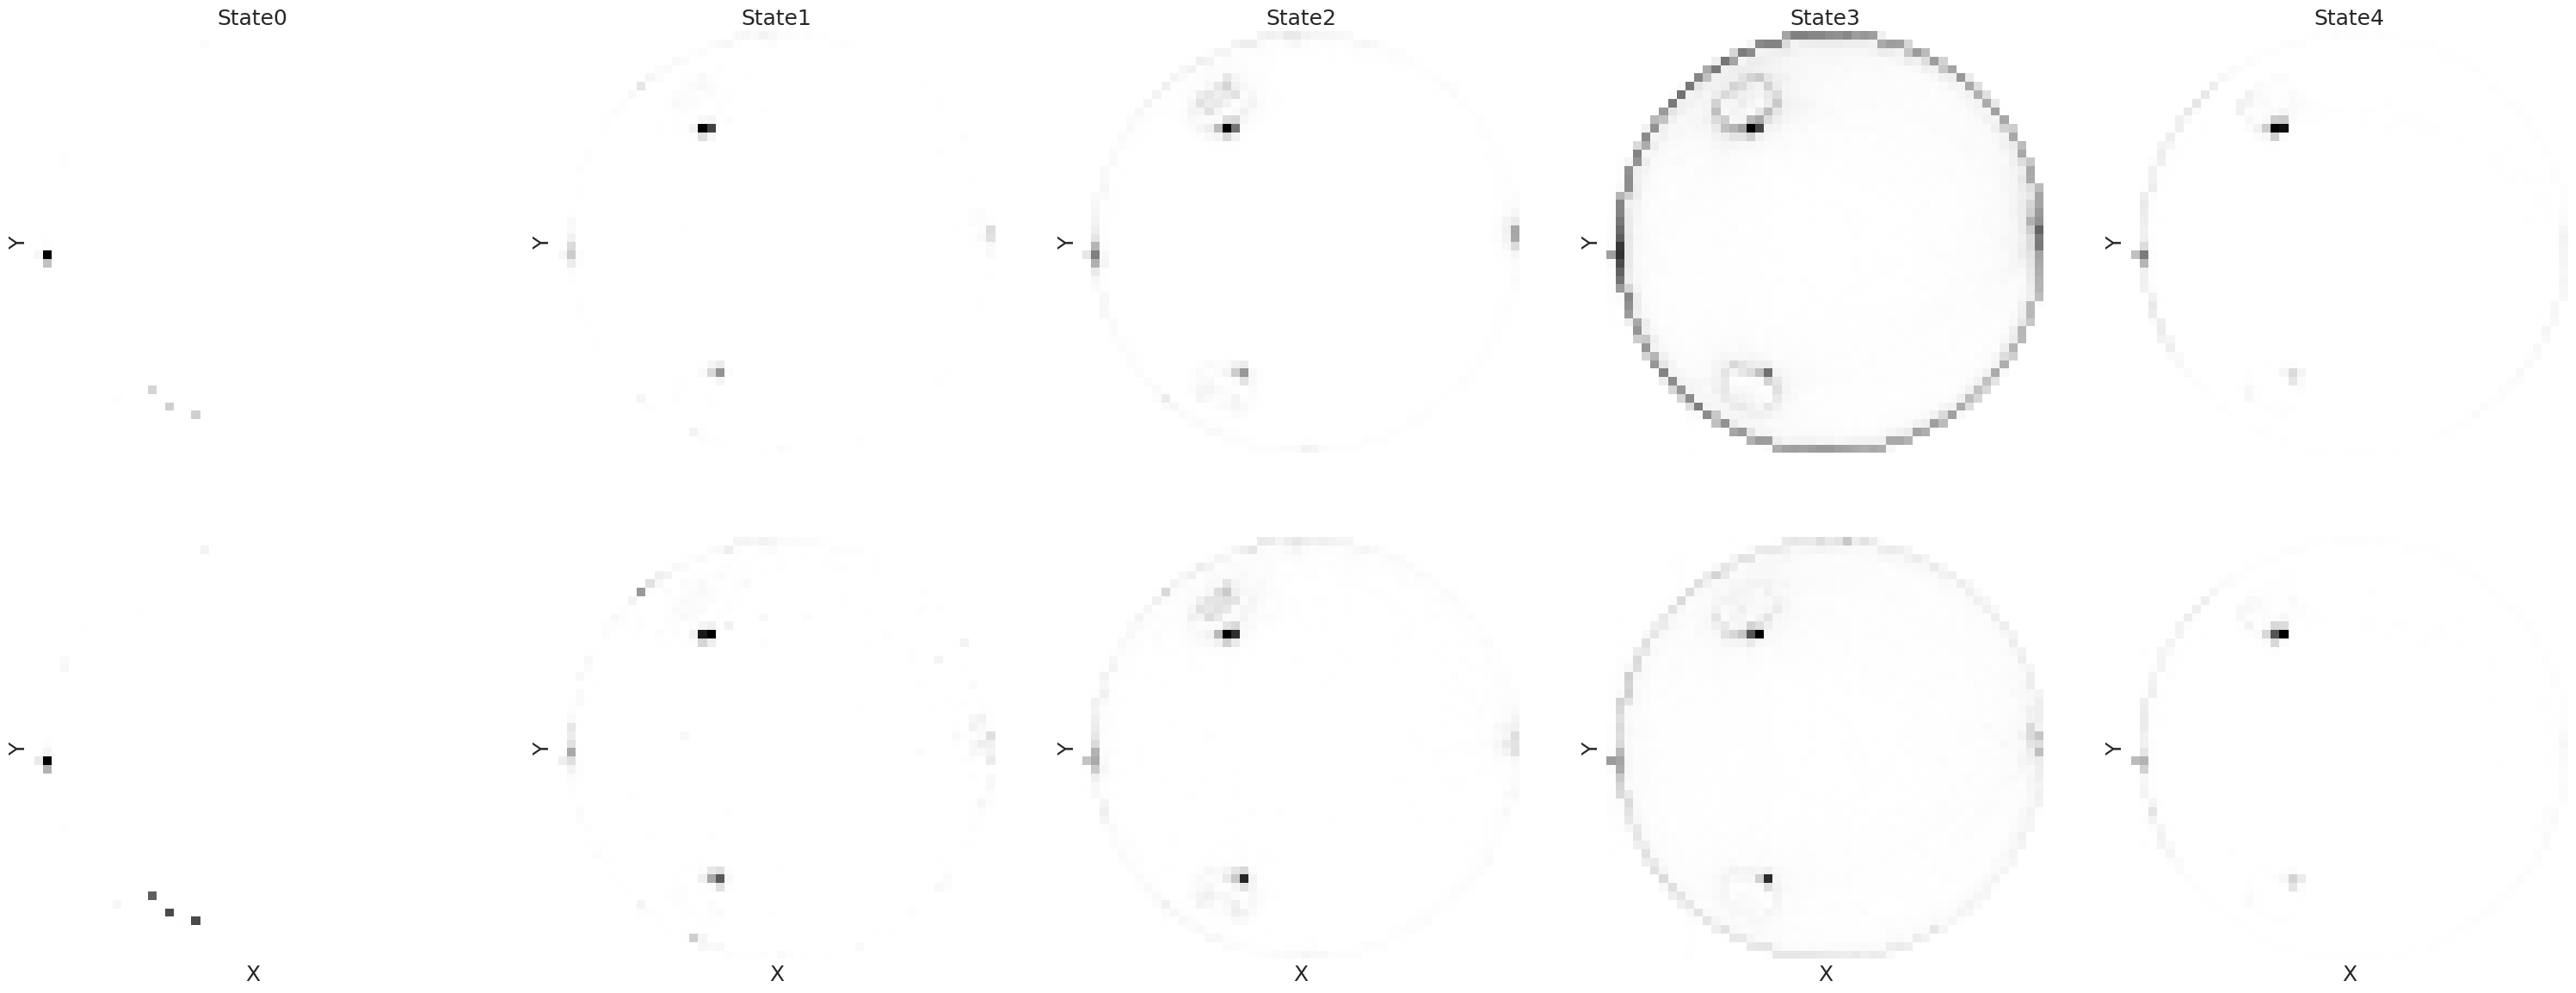

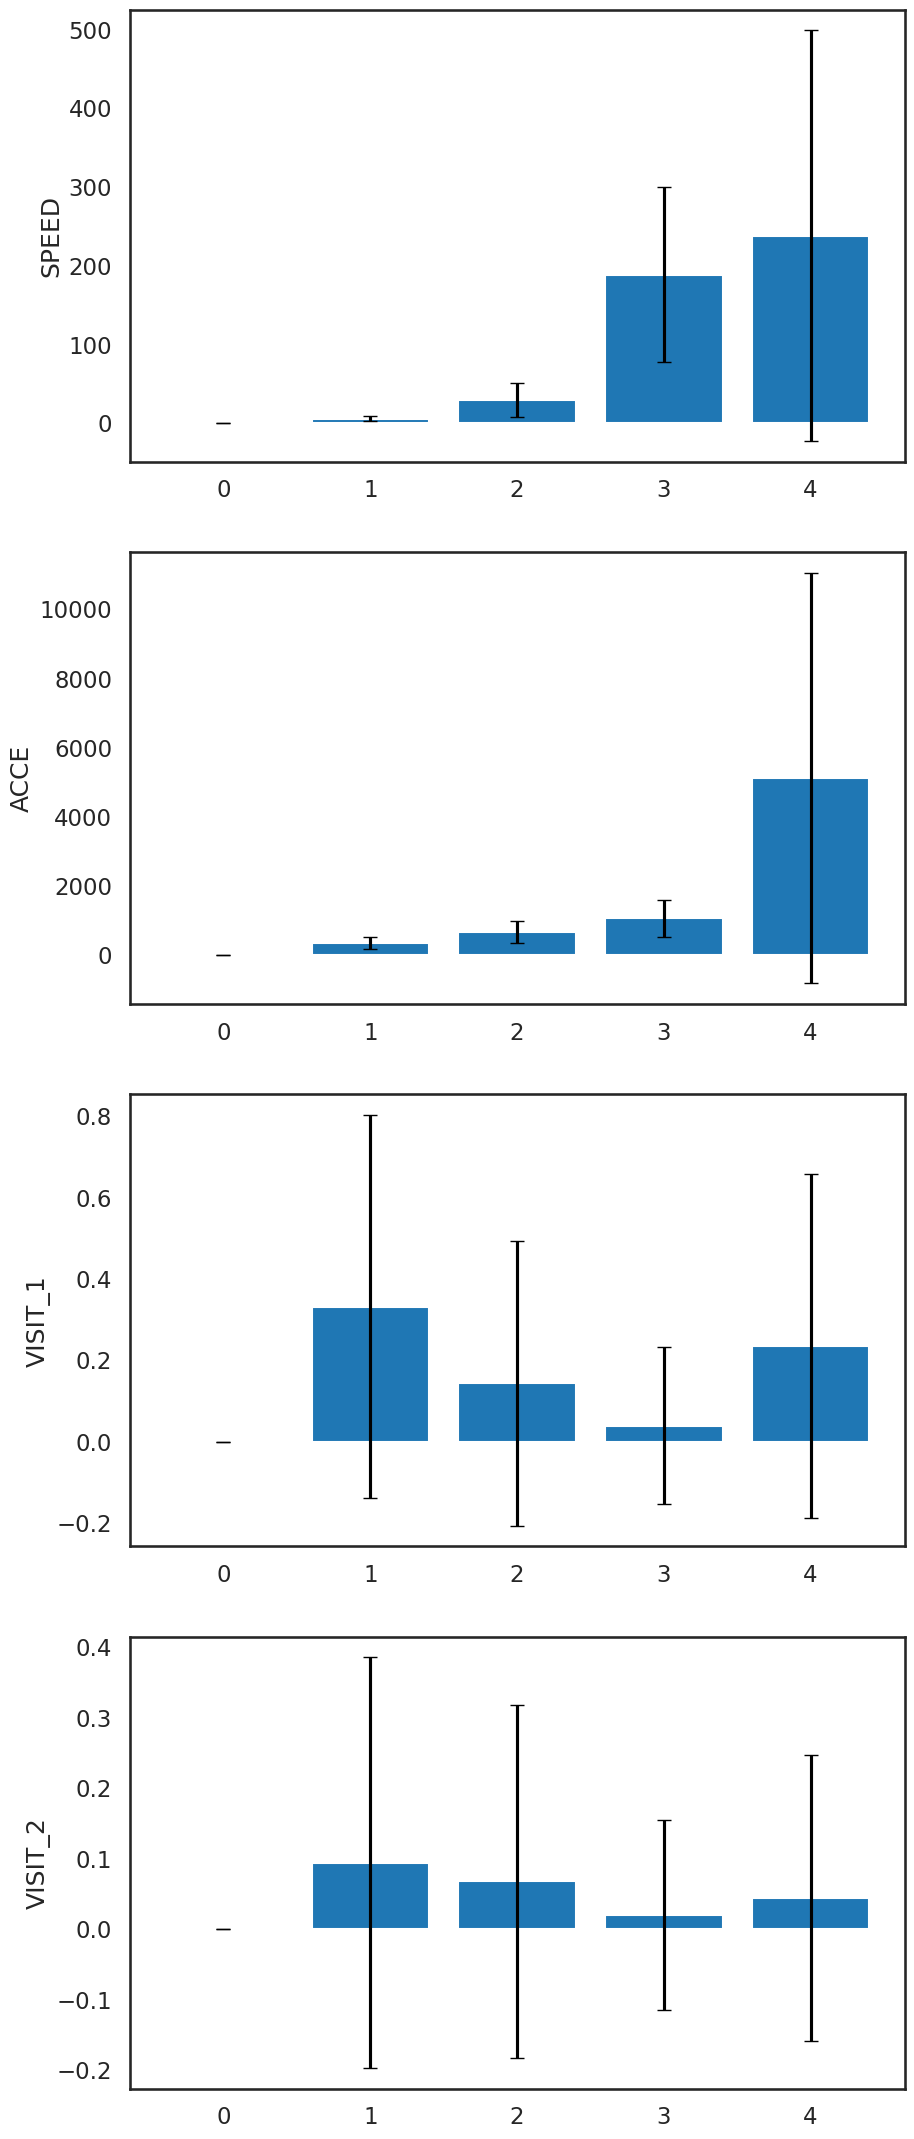

In [8]:
X, Y, SPEED, ACCE, VISIT_1, VISIT_2 = [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)]
HEATMAP = [[] for _ in range(N)]

for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(j)
    print(title)
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
    mouse_pos = DeleteRows(mouse_pos)
            
    obs = np.array(mouse_pos[feature])
    states = hmm.most_likely_states(obs)
        
    new_values = np.empty_like(states)
    for i, val in enumerate(index): new_values[states == val] = i
    states = new_values
            
    HMM.PlotStates(states, mouse_pos)
        
    x = mouse_pos['smoothed_position_x']
    y = mouse_pos['smoothed_position_y']
    speed = mouse_pos['smoothed_speed']
    acceleration = mouse_pos['smoothed_acceleration']
    VisitPatch1 = mouse_pos['Patch1']
    VisitPatch2 = mouse_pos['Patch2']
        
    for i in range(N):
        X[i] = np.concatenate([X[i], x[states==i]])
        Y[i] = np.concatenate([Y[i], y[states==i]])
        SPEED[i] = np.concatenate([SPEED[i], speed[states==i]])
        ACCE[i] = np.concatenate([ACCE[i], acceleration[states == i]])
        VISIT_1[i] = np.concatenate([VISIT_1[i], VisitPatch1[states == i]])
        VISIT_2[i] = np.concatenate([VISIT_2[i], VisitPatch2[states == i]])
        
    fig, axs = plt.subplots(1, N, figsize = (N*8-2,6))
    for i in range(N):
        heatmap, xedges, yedges, img = axs[i].hist2d(x[states == i], y[states == i], bins=[50, 50], range=[[215, 1235], [65, 1065]], cmap='binary', density=True)
        heatmap = np.nan_to_num(heatmap)
        HEATMAP[i].append(heatmap)
        axs[i].set_xlim(205, 1255)
        axs[i].set_ylim(45, 1085)
        axs[i].set_title('State' + str(i))
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Y')
    plt.show()

print("Overall: ")    

fig, axs = plt.subplots(2, N, figsize = (N*8-2,14))
for i in range(N):
    combined_heatmaps = np.array(HEATMAP[i])
    average_heatmap, std_deviation_heatmap = np.mean(combined_heatmaps, axis=0), np.std(combined_heatmaps, axis=0)
    sns.heatmap(np.rot90(average_heatmap), ax=axs[0,i], cmap='binary', cbar = False)
    sns.heatmap(np.rot90(std_deviation_heatmap), ax=axs[1,i], cmap='binary', cbar = False)
    
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[0,i].set_ylabel('Y')
    axs[1,i].set_ylabel('Y')
    axs[1,i].set_xlabel('X')
    axs[0,i].set_title('State' + str(i))    
plt.show()

# Speed, Acceleration, Visits in Patch 1, Visits in Patch 2
fig, axs = plt.subplots(4, 1, figsize = (10, 4*7-1))
DATA = [SPEED, ACCE, VISIT_1, VISIT_2]
FEATURE = ['SPEED', 'ACCE', 'VISIT_1', 'VISIT_2']
for data, i in zip(DATA, range(len(DATA))):
    means = [np.mean(arr) for arr in data]
    std_devs = [np.std(arr) for arr in data]
    axs[i].bar(range(N), means, yerr=std_devs, capsize=5)
    axs[i].set_xticks(range(0, 5), ['0', '1', '2', '3','4'])
    axs[i].set_ylabel(FEATURE[i])
plt.show()

ShortSession7


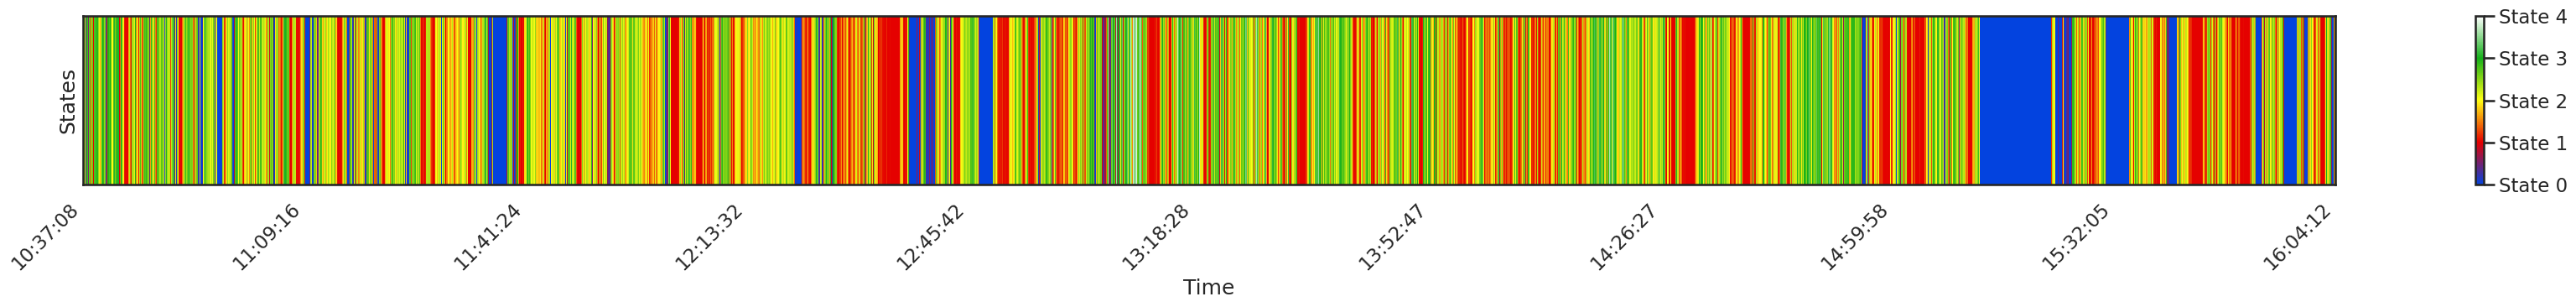

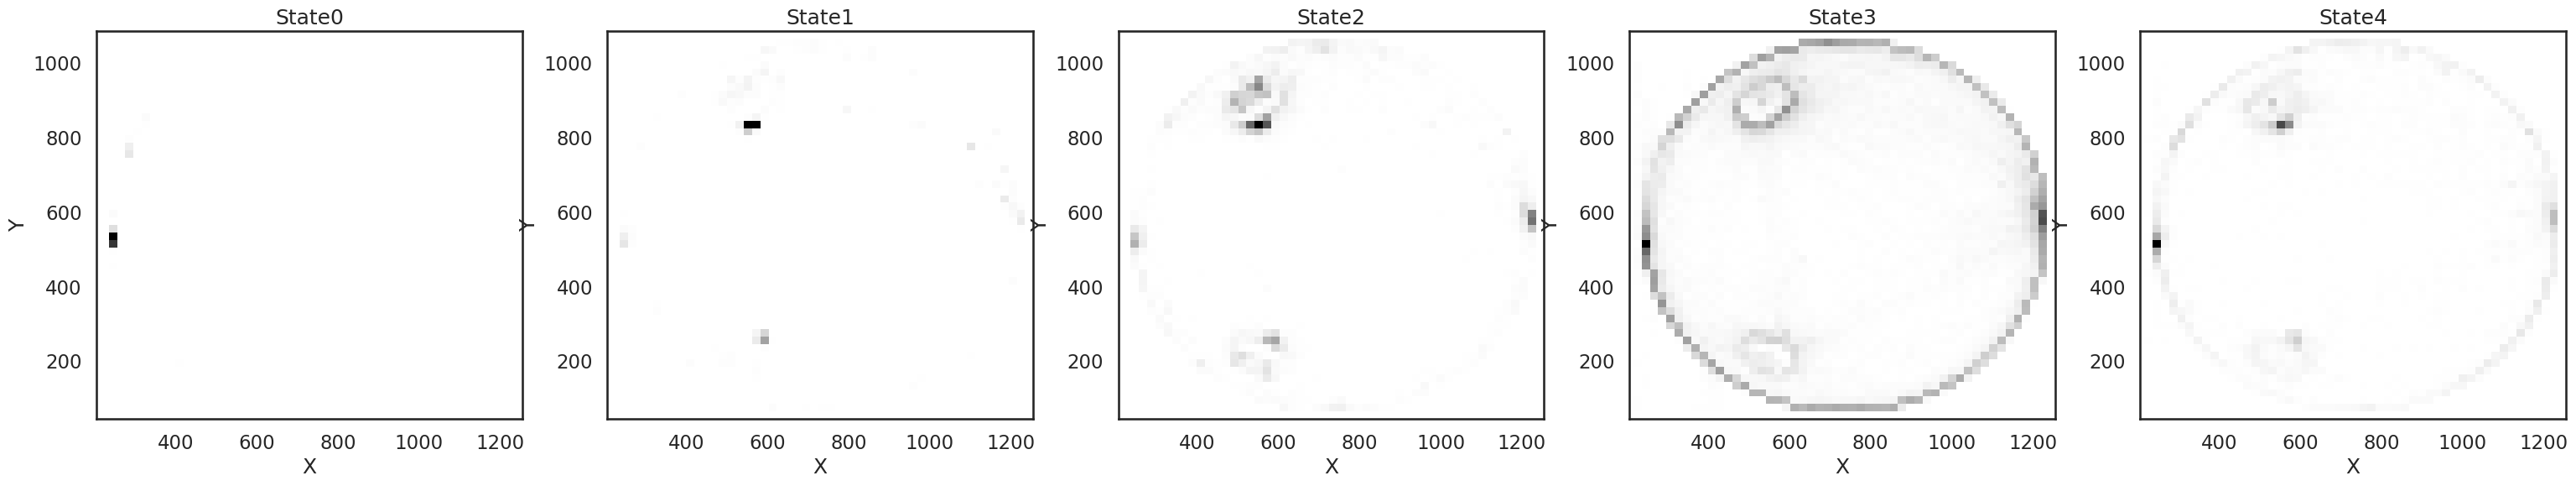

In [9]:
for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if j == 7:
        title = 'ShortSession'+str(j)
        print(title)
        mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
        mouse_pos = DeleteRows(mouse_pos)
                
        obs = np.array(mouse_pos[feature])
        states = hmm.most_likely_states(obs)
            
        new_values = np.empty_like(states)
        for i, val in enumerate(index): new_values[states == val] = i
        states = new_values
                
        HMM.PlotStates(states, mouse_pos)
            
        x = mouse_pos['smoothed_position_x']
        y = mouse_pos['smoothed_position_y']
        speed = mouse_pos['smoothed_speed']
        acceleration = mouse_pos['smoothed_acceleration']
        VisitPatch1 = mouse_pos['Patch1']
        VisitPatch2 = mouse_pos['Patch2']
            
        fig, axs = plt.subplots(1, N, figsize = (N*8-2,6))
        for i in range(N):
            heatmap, xedges, yedges, img = axs[i].hist2d(x[states == i], y[states == i], bins=[50, 50], range=[[215, 1235], [65, 1065]], cmap='binary', density=True)
            heatmap = np.nan_to_num(heatmap)
            axs[i].set_xlim(205, 1255)
            axs[i].set_ylim(45, 1085)
            axs[i].set_title('State' + str(i))
            axs[i].set_xlabel('X')
            axs[i].set_ylabel('Y')
        plt.show()


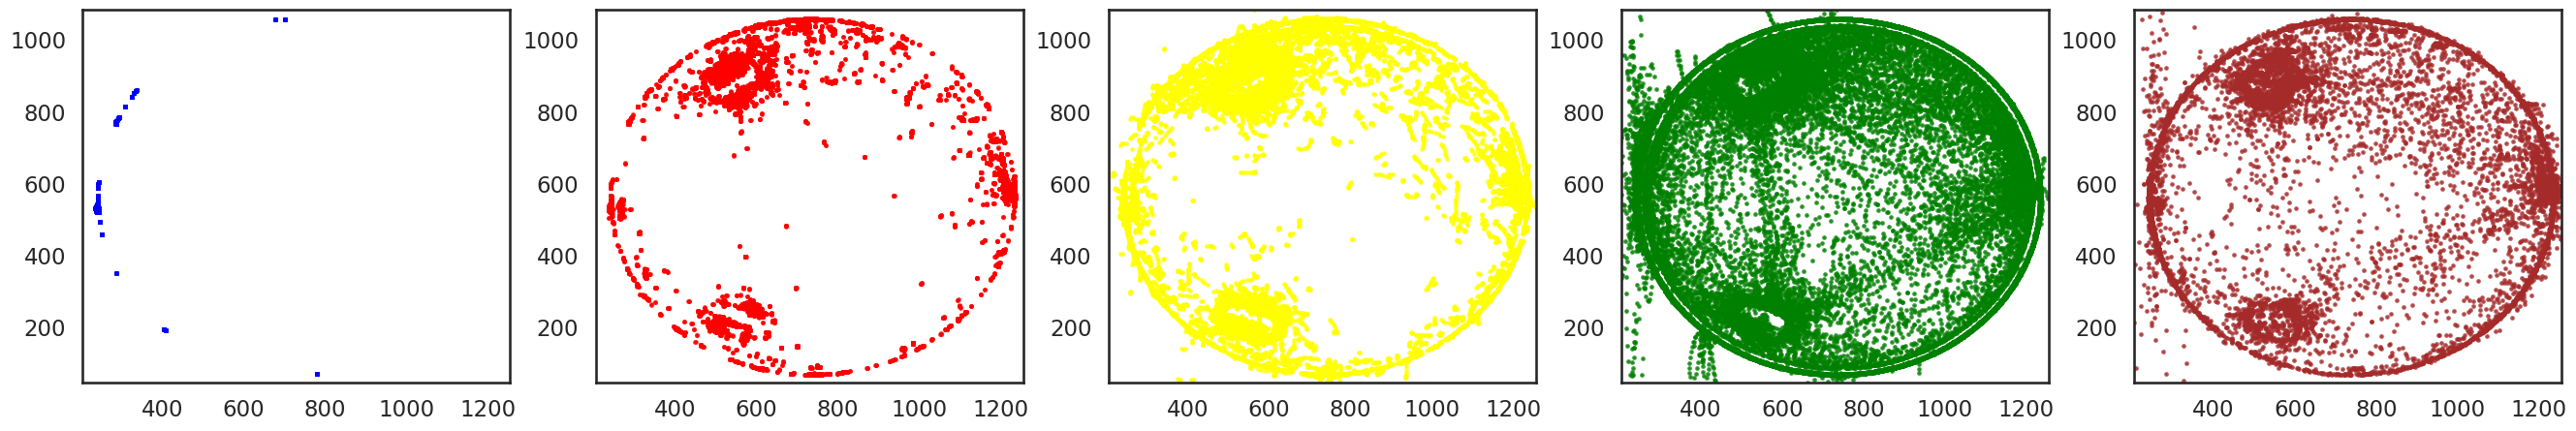

In [19]:
color_names = np.array(["blue","red","yellow", "green","brown"])
colors = color_names[states]
fig, axs = plt.subplots(1, 5, figsize = (33,5))
for i in range(N):
    axs[i].scatter(x[states == i], y[states == i], color = color_names[i], alpha = 0.7, s = 4)
    axs[i].set_xlim(205, 1255)
    axs[i].set_ylim(45, 1085)
plt.show()

In [10]:
mouse_pos['states'] = pd.Series(states, index=mouse_pos.index)

In [11]:
def AddRegressors(Visits_Patch1, Visits_Patch2):
        Visits_Patch1 = Visits_Patch1.copy()
        Visits_Patch2 = Visits_Patch2.copy()

        Visits_Patch1['DistanceTravelledinVisit'] = 0
        for i in range(len(Visits_Patch1)):
                start, end = Visits_Patch1.start[i], Visits_Patch1.end[i]
                
                encoder1 = api.load(root, exp02.Patch1.Encoder, start=start, end=end)
                '''                
                if encoder1.empty: Visits_Patch1.loc[i, 'DistanceTravelledinVisit'] = 0
                else:
                        w1 = -distancetravelled(encoder1.angle)
                        Visits_Patch1.loc[i, 'DistanceTravelledinVisit'] = w1[0]-w1[-1]'''
                if not encoder1.empty: 
                        w1 = -distancetravelled(encoder1.angle)
                        Visits_Patch1.loc[i, 'DistanceTravelledinVisit'] = w1[0]-w1[-1]
        
        Visits_Patch1['PelletsInLastVisitSelf'] = 0
        Visits_Patch1['PelletsInLastVisitOther'] = 0
        for i in range(1,len(Visits_Patch1)):
                start, end = Visits_Patch1.start[i-1], Visits_Patch1.end[i-1]
                
                pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
                Visits_Patch1.loc[i, 'PelletsInLastVisitSelf'] = len(pellets_patch1)
                
                prior_timestamps = Visits_Patch2[Visits_Patch2['end'] < Visits_Patch1.start[i]]
                '''if prior_timestamps.empty: Visits_Patch1.loc[i, 'PelletsInLastVisitOther'] = 0
                else:'''
                if not prior_timestamps.empty:
                        start_, end_ = prior_timestamps.iloc[-1]['start'], prior_timestamps.iloc[-1]['end']
                        pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start_, end=end_)
                        Visits_Patch1.loc[i, 'PelletsInLastVisitOther'] = len(pellets_patch2)
                
        Visits_Patch2['DistanceTravelledinVisit'] = 0
        for i in range(len(Visits_Patch2)):
                start, end = Visits_Patch2.start[i], Visits_Patch2.end[i]
                encoder2 = api.load(root, exp02.Patch2.Encoder, start=start, end=end)
                '''                
                if encoder2.empty: Visits_Patch2.loc[i, 'DistanceTravelledinVisit'] = 0
                else:
                        w2 = -distancetravelled(encoder2.angle)
                        Visits_Patch2.loc[i, 'DistanceTravelledinVisit'] = w2[0]-w2[-1]'''
                if not encoder2.empty:
                        w2 = -distancetravelled(encoder2.angle)
                        Visits_Patch2.loc[i, 'DistanceTravelledinVisit'] = w2[0]-w2[-1]
        
                
        Visits_Patch2['PelletsInLastVisitSelf'] = 0
        Visits_Patch2['PelletsInLastVisitOther'] = 0
        for i in range(1,len(Visits_Patch2)):
                start, end = Visits_Patch2.start[i-1], Visits_Patch2.end[i-1]

                pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
                Visits_Patch2.loc[i, 'PelletsInLastVisitSelf'] = len(pellets_patch2)
                
                prior_timestamps = Visits_Patch1[Visits_Patch1['end'] < Visits_Patch2.start[i]]
                '''if prior_timestamps.empty: Visits_Patch2.loc[i, 'PelletsInLastVisitOther'] = 0
                else:
                        start_, end_ = prior_timestamps.iloc[-1]['start'], prior_timestamps.iloc[-1]['end']
                        pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start_, end=end_)
                        Visits_Patch2.loc[i, 'PelletsInLastVisitOther'] = len(pellets_patch1)'''
                if not prior_timestamps.empty: 
                        start_, end_ = prior_timestamps.iloc[-1]['start'], prior_timestamps.iloc[-1]['end']
                        pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start_, end=end_)
                        Visits_Patch2.loc[i, 'PelletsInLastVisitOther'] = len(pellets_patch1)

        return Visits_Patch1, Visits_Patch2

In [17]:
def VisitPatch(mouse_pos, patch = 'Patch1', period = 5):
    # Pre-processing
    '''
    mouse_pos['speed_ave'] = mouse_pos['smoothed_speed'].rolling(speed_ave_time).mean()
    mouse_pos['acceleration_ave'] = mouse_pos['smoothed_acceleration'].rolling(acce_ave_time).mean()
    mouse_pos['weight_ave'] = mouse_pos['weight'].rolling(weight_ave_time).mean()
    '''
    
    Visits = {'start':[],'end':[], 'duration':[], 'speed':[], 'acceleration':[], 'weight':[],'state':[]}
    
    groups = mouse_pos[patch].ne(mouse_pos[patch].shift()).cumsum()
    visits = mouse_pos[mouse_pos[patch] == 1].groupby(groups)[patch]
    for name, group in visits:
        Visits['start'].append(group.index[0])
        Visits['end'].append(group.index[-1])
        
        start_time = group.index[0]
        end_time = start_time - pd.Timedelta(seconds = period)
        if end_time < mouse_pos.index[0]: end_time = mouse_pos.index[0]
        
        pre_visit_data = mouse_pos.loc[end_time:start_time]
        
        pre_visit_data['states'].mean()
        
        Visits['duration'].append(mouse_pos.loc[group.index[0], patch + '_Leave_Time_Seconds'])
        Visits['speed'].append(pre_visit_data['smoothed_speed'].mean())
        Visits['acceleration'].append(pre_visit_data['smoothed_acceleration'].mean())
        Visits['weight'].append(pre_visit_data['weight'].mean())
        Visits['state'].append(pre_visit_data['states'].value_counts().idxmax())
    
    return pd.DataFrame(Visits)

In [20]:
Visits_Patch1_Duration = [np.array([]) for _ in range(N)]
Visits_Patch2_Duration = [np.array([]) for _ in range(N)]
Visits_Patches_Duration = [np.array([]) for _ in range(N)]

for i in range(N):
    v1, v2 = Visits_Patch1[Visits_Patch1['state'] == i].duration.to_numpy(), Visits_Patch2[Visits_Patch2['state'] == i].duration.to_numpy()
    
    Visits_Patch1_Duration[i] = np.concatenate((Visits_Patch1_Duration[i], v1))
    Visits_Patches_Duration[i] = np.concatenate((Visits_Patches_Duration[i], Visits_Patch1_Duration[i]))
    
    Visits_Patch2_Duration[i] = np.concatenate((Visits_Patch2_Duration[i], v2))
    Visits_Patches_Duration[i] = np.concatenate((Visits_Patches_Duration[i], Visits_Patch2_Duration[i]))

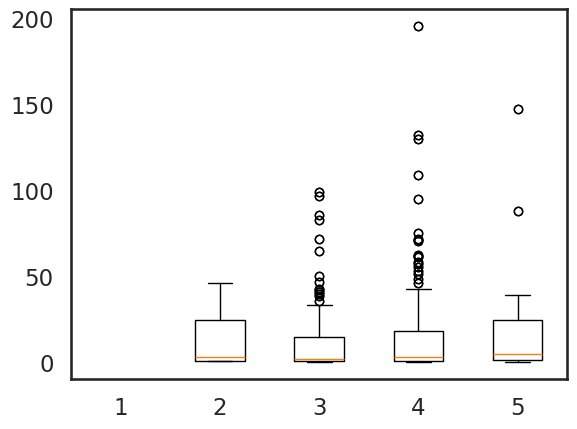

In [23]:
plt.boxplot(Visits_Patches_Duration)
plt.show()

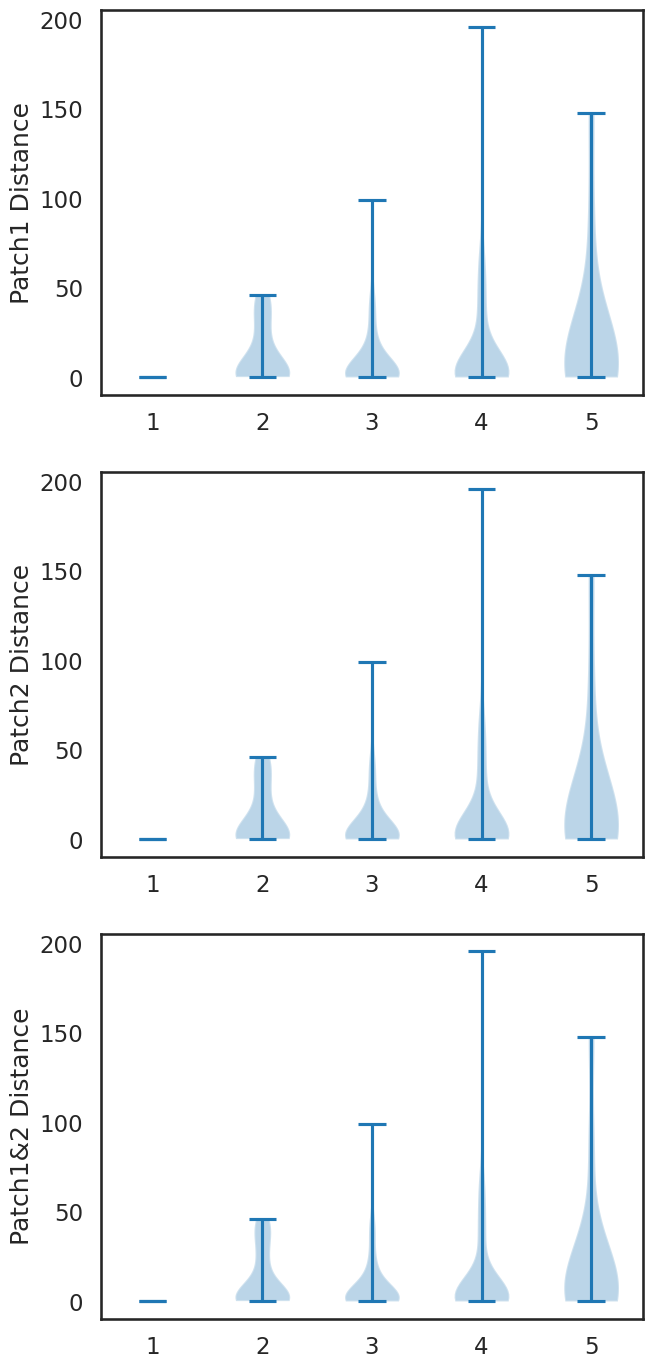

In [48]:
fig, axs = plt.subplots(3,1,figsize = (7,17))
axs[0].violinplot(Visits_Patch1_Duration)
axs[0].set_ylabel("Patch1 Distance")
axs[1].violinplot(Visits_Patch2_Duration)
axs[1].set_ylabel("Patch2 Distance")
axs[2].violinplot(Visits_Patches_Duration)
axs[2].set_ylabel("Patch1&2 Distance")
plt.savefig('/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/images/StateBeforeVisit/'+title+'.png')

### Fit the model using all sessions

ShortSession0
ShortSession1
ShortSession2
ShortSession3
ShortSession4
ShortSession5
ShortSession6
ShortSession7
ShortSession8
ShortSession9
ShortSession10
ShortSession11


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

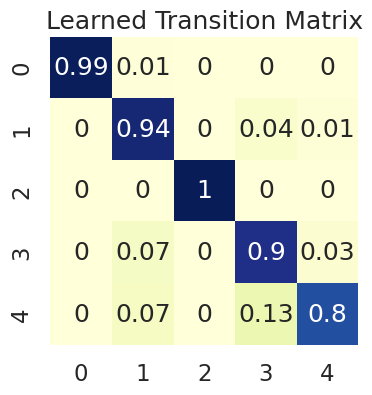

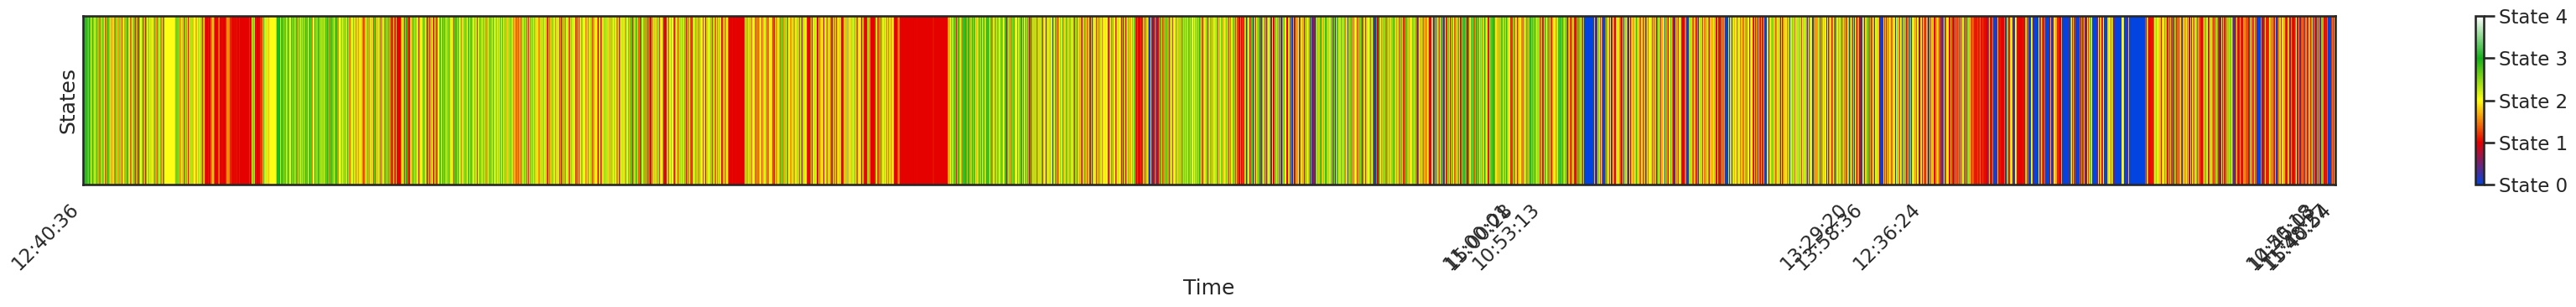

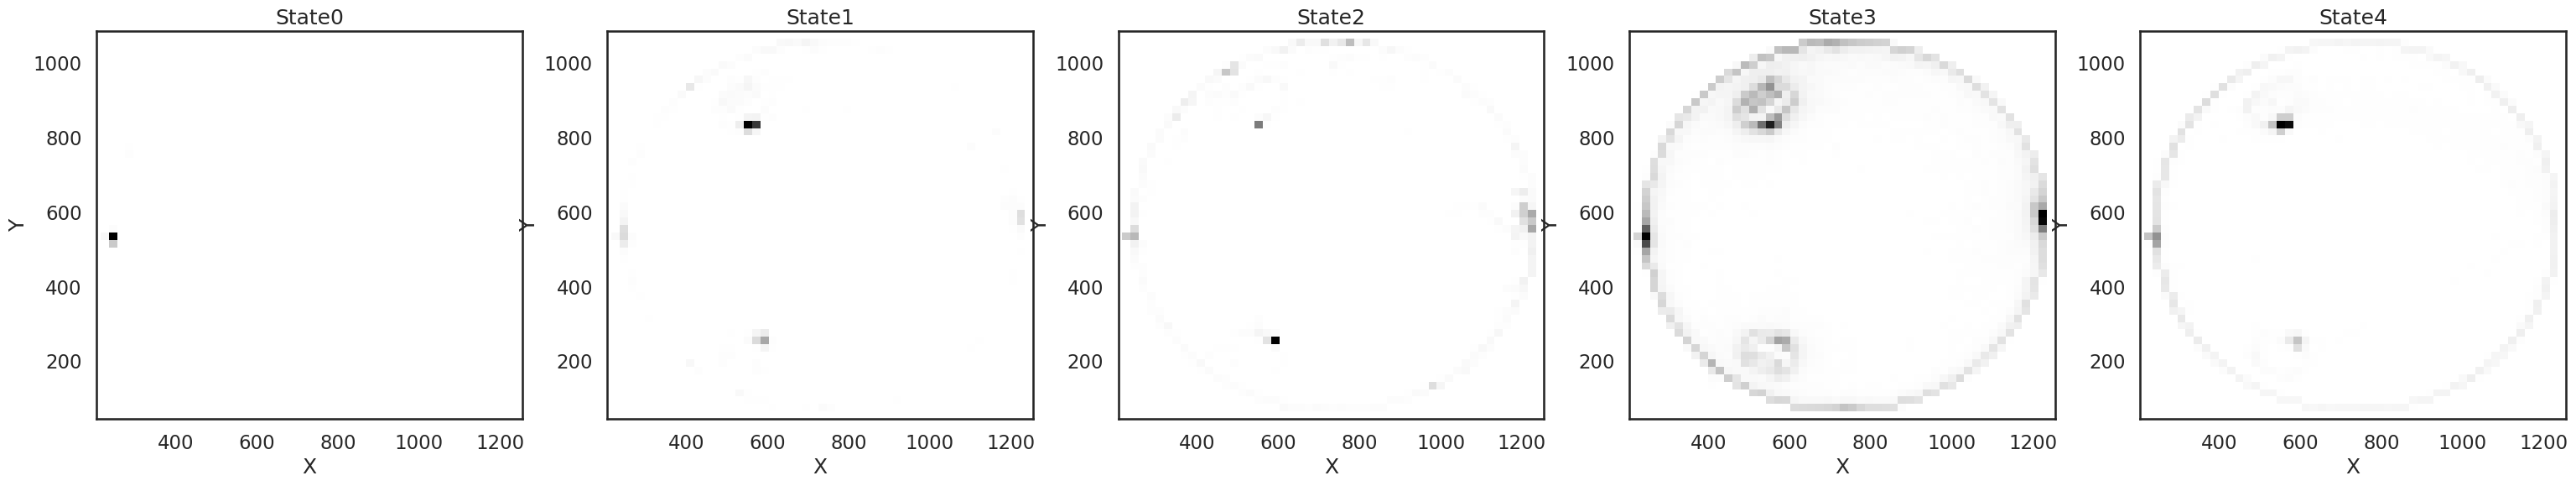

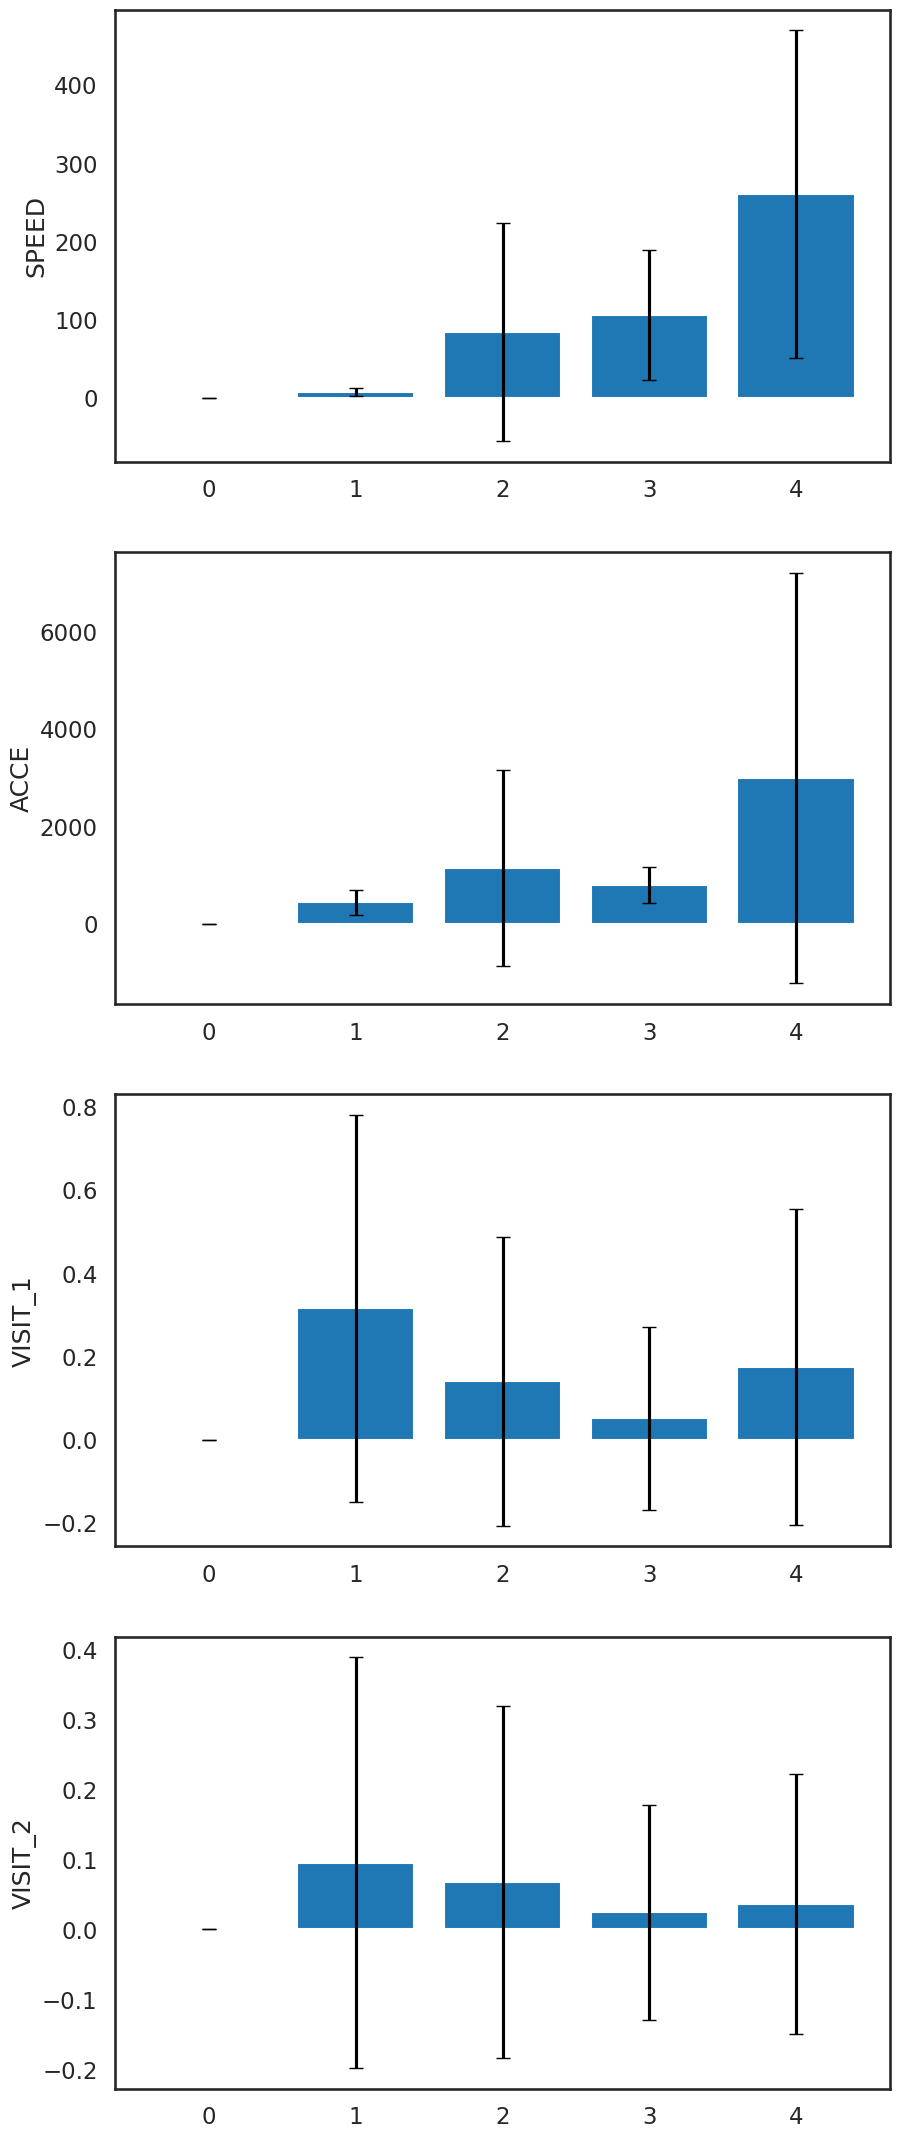

In [18]:
SPEED, ACCE, VISIT_Pref, VISIT_UnPref = [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)], [np.array([]) for _ in range(N)]
feature = ['weight', 'smoothed_speed', 'smoothed_acceleration']

dfs = []

for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(j)
    print(title)
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
    mouse_pos = DeleteRows(mouse_pos)
    
    mouse_pos = mouse_pos.loc[:,['weight', 'smoothed_position_x', 'smoothed_position_y', 'smoothed_speed', 'smoothed_acceleration','Patch1','Patch2']]
    dfs.append(mouse_pos)

mouse_pos = dfs[0]
for df in dfs[1:]: mouse_pos = mouse_pos.add(df, fill_value=0)
            
obs = np.array(mouse_pos[feature])
hmm, states, transition_mat, lls = HMM.FitHMM(obs, num_states = N, n_iters = 50)

state_mean_speed = hmm.observations.params[0].T[1]
index = np.argsort(state_mean_speed, -1)
        
HMM.PlotTransition(transition_mat[index].T[index].T)

        
new_values = np.empty_like(states)
for i, val in enumerate(index): new_values[states == val] = i
states = new_values
            
HMM.PlotStates(states, mouse_pos)
        
x = mouse_pos['smoothed_position_x']
y = mouse_pos['smoothed_position_y']
speed = mouse_pos['smoothed_speed']
acceleration = mouse_pos['smoothed_acceleration']
VisitPatch1 = mouse_pos['Patch1']
VisitPatch2 = mouse_pos['Patch2']

for i in range(N):
    SPEED[i] = np.concatenate([SPEED[i], speed[states==i]])
    ACCE[i] = np.concatenate([ACCE[i], acceleration[states == i]])
    VISIT_1[i] = np.concatenate([VISIT_1[i], VisitPatch1[states == i]])
    VISIT_2[i] = np.concatenate([VISIT_2[i], VisitPatch2[states == i]])
        
fig, axs = plt.subplots(1, N, figsize = (N*8-2,6))
for i in range(N):
    heatmap, xedges, yedges, img = axs[i].hist2d(x[states == i], y[states == i], bins=[50, 50], range=[[215, 1235], [65, 1065]], cmap='binary', density=True)
    axs[i].set_xlim(205, 1255)
    axs[i].set_ylim(45, 1085)
    axs[i].set_title('State' + str(i))
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
plt.show()

fig, axs = plt.subplots(4, 1, figsize = (10, 4*7-1))
DATA = [SPEED, ACCE, VISIT_1, VISIT_2]
FEATURE = ['SPEED', 'ACCE', 'VISIT_1', 'VISIT_2']
for data, i in zip(DATA, range(len(DATA))):
    means = [np.mean(arr) for arr in data]
    std_devs = [np.std(arr) for arr in data]
    axs[i].bar(range(N), means, yerr=std_devs, capsize=5)
    axs[i].set_xticks(range(0, 5), ['0', '1', '2', '3','4'])
    axs[i].set_ylabel(FEATURE[i])
plt.show()